In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from time import time
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [9]:
#!pip install pip install distfit

In [10]:
from PIL import Image
from itertools import product
import os
def tile(filename, dir_in, dir_out):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    #image = img.copy()
    # Draw a rectangle with red borders and thickness of 5 px
    #image = cv2.rectangle(image, top_left, bottom_right, colour, thickness)
    probable = list(range(32,72,2))
    dim = []
    for i in probable:
        #print(i)
        if(w*h)%i == 0:
            dim.append(i)
    d = dim[int(len(dim)/2)]
    print(d)
    #row, col = img_n.shape
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    #std = []
    # Set the line color to red in BGR
    colour = (255, 255, 255)

    # Set line thickness to 5px
    thickness = 2
    left = [] 
    upper=[]
    right =[]
    lower = []
    mean = []
    inc = 0
    for i, j in grid:
        box = (j, i, j+d, i+d)
        left.append(j)
        upper.append(i)
        right.append(j+d)
        lower.append(i+d)
        out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        #std.append(img.crop(box).std())
        mean.append(np.mean(img.crop(box)))
        img.crop(box).save(out)
        inc = inc + 1
        
    return left,upper,right,lower, mean

In [11]:
def selectROI(left,upper,right,lower, mean):
    #target between medium and high mean
    #remove low mean
    medium_mean = int(np.fix((max(mean)+min(mean))/2))
    high_mean  = int(max(mean))
    selected_values = list(x for x in mean if medium_mean < x < high_mean-1)
    #print(np.mean(selected_values))
    #print(selected_values)
    #value_select = list(x for x in selected_values if int(np.fix(x)) == int(np.fix(np.mean(selected_values))))
    #list(x for x in value_select if medium_mean <= x < high_mean)
    #if len(selected_values) > 5:
    while len(selected_values) >= 15:
        selected_values = list(x for x in selected_values if (np.mean(selected_values)) < x < (np.max(selected_values)))
        #print(selected_values)
    #value_select = list(x for x in value_select if (np.mean(value_select)) < x < (np.max(value_select)-1))
    #value_select = list(x for x in value_select if (np.mean(value_select)) < x < (np.max(value_select)-1))
    
    #print(selected_values)
    lefts = []
    uppers = []
    rights = []
    lowers = []
    for i in selected_values:
        index = mean.index(i)
        lefts.append(left[index])
        uppers.append(upper[index])
        rights.append(right[index])
        lowers.append(lower[index])
    #elif len(value_select) >1 and len(value_select) != 0:
    #    indexes = list(x for x in mean.index(np.mean(value_select)))
    #    left = list(x for x in left[indexes])
    #    upper  = list(x for x in upper[indexes])
    #    right  = list(x for x in right[indexes])
    #    lower  = list(x for x in lower[indexes])
   
    return lefts,uppers,rights,lowers
    

In [12]:
def estimate_noise_std(img, average=True):
    """Estimate standard deviation of noise in ``img``.

    The algorithm, given in [Immerkaer1996], estimates the noise in an image.

    Parameters
    ----------
    img : array-like
        Array to estimate noise in.
    average : bool
        If ``True``, return the mean noise in the image, otherwise give a
        pointwise estimate.

    Returns
    -------
    noise : float

    Examples
    --------
    Create image with noise 1.0, verify result

    >>> img = np.random.randn(10, 10)
    >>> result = estimate_noise_std(img)  # should be about 1

    Also works with higher dimensional arrays

    >>> img = np.random.randn(3, 3, 3)
    >>> result = estimate_noise_std(img)

    The method can also estimate the noise pointwise (but with high
    uncertainity):

    >>> img = np.random.randn(3, 3, 3)
    >>> result = estimate_noise_std(img, average=False)

    References
    ----------
    [Immerkaer1996] Immerkaer, J. *Fast Noise Variance Estimation*.
    Computer Vision and Image Understanding, 1996.
    """
    import scipy.signal
    import functools
    img = np.asarray(img, dtype='float')

    M = functools.reduce(np.add.outer, [[-1, 2, -1]] * img.ndim)

    convolved = scipy.signal.fftconvolve(img, M, mode='valid')
    if average:
        conv_var = np.sum(convolved ** 2) / convolved.size
    else:
        conv_var = convolved ** 2

        # Pad in order to retain shape
        conv_var = np.pad(conv_var, pad_width=1, mode='edge')

    scale = np.sum(np.square(M))
    sigma = np.sqrt(conv_var / scale)

    return sigma 

In [13]:
def visualize_the_ROI(filename,left_select,upper_select,right_select,lower_select,out):
    img = cv2.imread(filename,0)
    row, col = img.shape
    #gauss = np.random.normal(10,10,(row,col))
    #noisy = img + gauss
    smooth_parts = []
    #(left, upper, right, lower) (0, 0, 70, 70)
    # Set the coordinates of top left corner of rectangle
    #(910, 630, 980, 700)(896, 640, 960, 704) (832, 512, 896, 576) (960, 704, 1024, 768) (704, 512, 768, 576)(832, 64, 896, 128)
    #(192, 64, 256, 128) (0, 128, 64, 192) (0, 576, 64, 640)
    for i in range(0,len(left_select)):
        top_left = (left_select[i], upper_select[i])

        #cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2) 
        #roi_image = gray[y:y+h, x:x+w]
        # Set the coordinates of bottom right corner of rectangle
        bottom_right = (right_select[i], lower_select[i])

        # Set the line color to red in BGR
        colour = (255, 255, 255)

        # Set line thickness to 5px
        thickness = 5

        image = img.copy()
        # Draw a rectangle with red borders and thickness of 5 px
        image = cv2.rectangle(image, top_left, bottom_right, colour, thickness)


        smooth_part = img[upper_select[i]:lower_select[i],left_select[i]:right_select[i]]
        smooth_parts.append(smooth_part)
        #histogram, bin_edges = np.histogram(img, bins=256, range=(0, 1))
        # Create figure and axes
        fig = plt.figure(figsize =(10, 7))
        plt.title('Selected ROI : ' + str(i))
        plt.subplot(221),plt.imshow(image,cmap = 'gray')
        plt.title('Noisy Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(222),plt.imshow(smooth_part,cmap = 'gray')
        plt.title('Region of Interest - ROI (probability)'), plt.xticks([]), plt.yticks([])
        plt.subplot(223),

        n, bins, patches = plt.hist(img.ravel(),256,[0,256])#; plt.show()
        #plt.title('Histogram - STD : ' + str(round(estimate_noise_std(img),2)) ), 
        plt.ylabel('Pixel count')
        plt.xlabel('Color level')
        #plt.text(150, 7250, r'$\sigma='+str(round(estimate_noise_std(img),2))+'$')
        plt.grid(True)
        plt.colorbar(orientation='horizontal')
        plt.clim(0, 256) 
        plt.subplot(224)#,plt.hist(smooth_part.ravel(),256,[0,256])#; plt.show()
        n, bins, patches = plt.hist(smooth_part.ravel(),256,[0,256])#; plt.show()
        #plt.title('Histogram - STD : ' + str(round(estimate_noise_std(smooth_part),2)) ), 
        plt.ylabel('Pixel count')
        plt.xlabel('Color level')
        #plt.text(180, 65, r'$\sigma='+str(round(estimate_noise_std(smooth_part),2))+'$')
        plt.grid(True)
        plt.colorbar(orientation='horizontal')
        plt.clim(0, 256) 
        plt.tight_layout()
        plt.savefig(os.path.splitext(out)[0]+'_'+str(i)+'.png', dpi=300)
        plt.show()
    return smooth_parts

In [14]:
from scipy.stats import poisson

# gaussian to use with array (numpy)
def gaussianfunc(x, mean, sigma):
    a = sigma*np.sqrt(2*np.pi)
    b = np.power((x-mean), 2.0)/(2*np.power(sigma, 2.0))
    return (1/a)*np.exp(-b)
    
# poisson to use with array (numpy) ADJUST THE VALUE

#calculate probability
def poissonfunc(k,mu):
    return poisson.pmf(k, mu)
    
    
# Model of gaussian noise by robust fitting without ROI
# works well for truncated histogram: if there is saturation !!!
def computemodelgaussiannoise0(src):
    #sel = selectregion(src)
    hist1 = cv2.calcHist([src],[0],None,[256],[0,256])
    hist = hist1/src.size
    a = cv2.blur(hist[1:255], (1,13)) #smoothing of histogram with value of 0 and 255 removed (saturation)
    sigma = np.max(a)*np.sqrt(2*np.pi)
    sigma = 1/sigma
    mean = np.where(a == np.max(a))[0][0]
    return mean, sigma
 
    
    # Model of poisson noise by robust fitting without ROI
# works well for truncated histogram: if there is saturation !!!
def computemodelpoisson0(src):
    #sel = selectregion(src)
    hist1 = cv2.calcHist([src],[0],None,[256],[0,256])
    hist = hist1/src.size
    a = cv2.blur(hist[1:255], (1,13)) #smoothing of histogram with value of 0 and 255 removed (saturation)
    mean = np.where(a == np.max(a))[0][0]
    sigma = np.sqrt(mean)
    return mean, sigma


In [15]:

# residual along with gaussian model
def computeresidualgaussian(src):
    hist1 = cv2.calcHist([src],[0],None,[256],[0,256])
    hist = hist1/src.size
    #a = cv2.blur(hist[1:255], (1,13)) #smoothing of histogram with value of 0 and 255 removed (saturation)
    a = hist
    sigma = np.max(a)*np.sqrt(2*np.pi)
    sigma = 1/sigma
    mean = np.where(a == np.max(a))[0][0]
    residu = 0
    for i in range(1,254):
        residu = residu + (hist[i] - gaussianfunc(src, mean, sigma))**2
    return mean,sigma,residu
        

# residual along with poisson model
def computeresidualpoisson(src):
    hist1 = cv2.calcHist([src],[0],None,[256],[0,256])
    hist = hist1/src.size
    #a = cv2.blur(hist[1:255], (1,13)) #smoothing of histogram with value of 0 and 255 removed (saturation)
    a = hist
    mean = np.where(a == np.max(a))[0][0]
    sigma = np.sqrt(mean)
    residu = 0
    for x in range(1,254):
        residu = residu + (hist[x]-poissonfunc(src, mean))**2
    return mean,sigma,residu

# Segmentation and Noise Estimation Scan speed 01

48


/tmp/ipykernel_26040/1017964780.py:48: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')
/tmp/ipykernel_26040/1017964780.py:57: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')


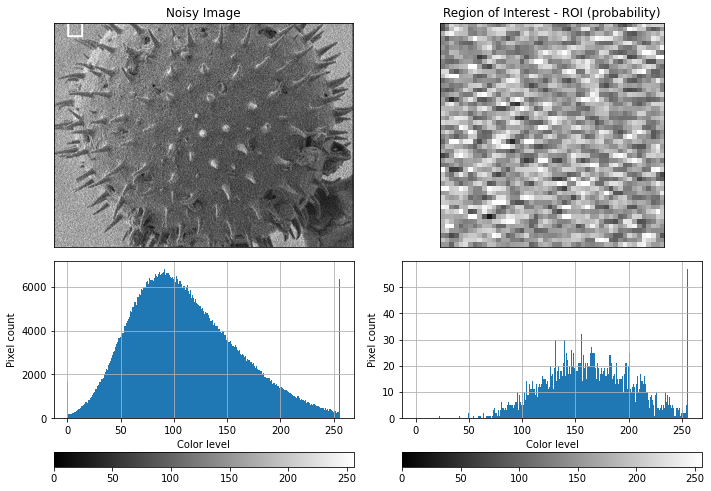

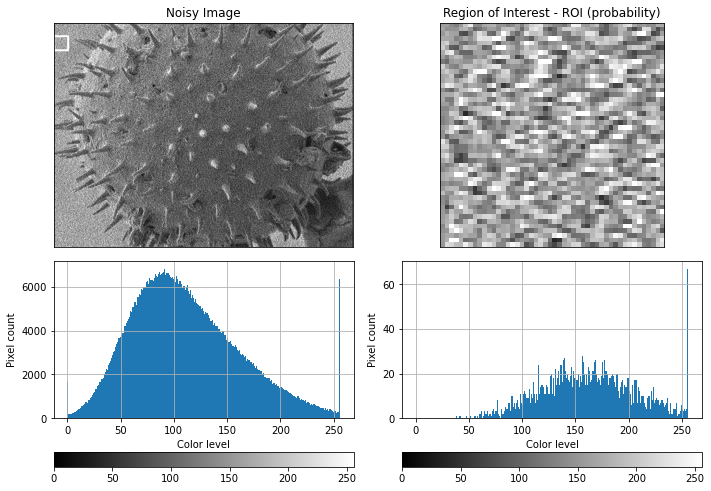

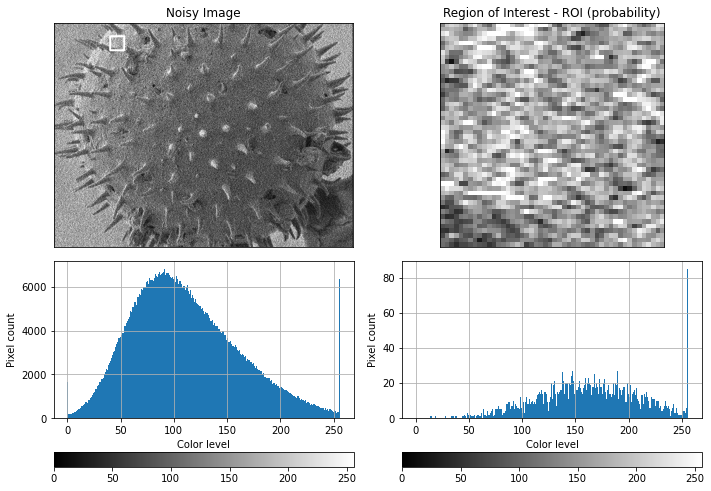

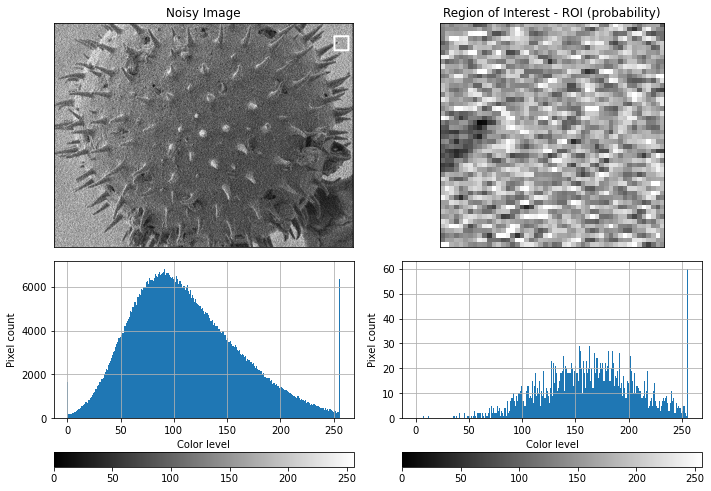

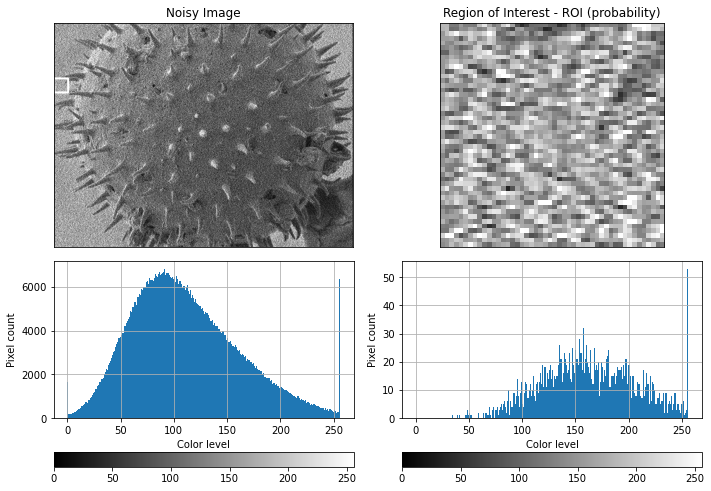

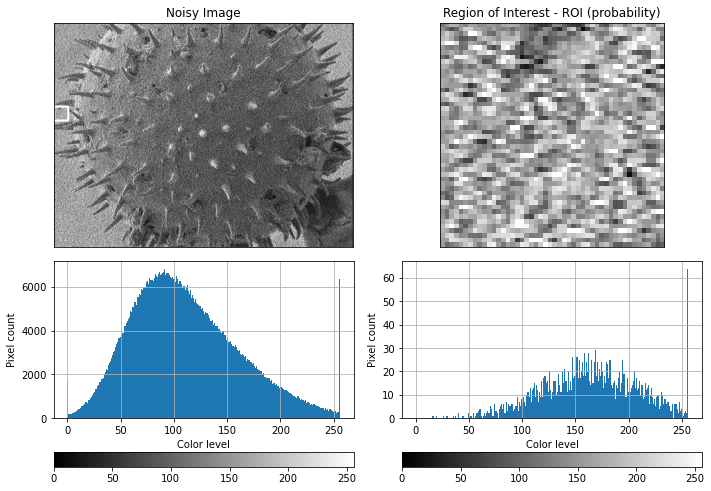

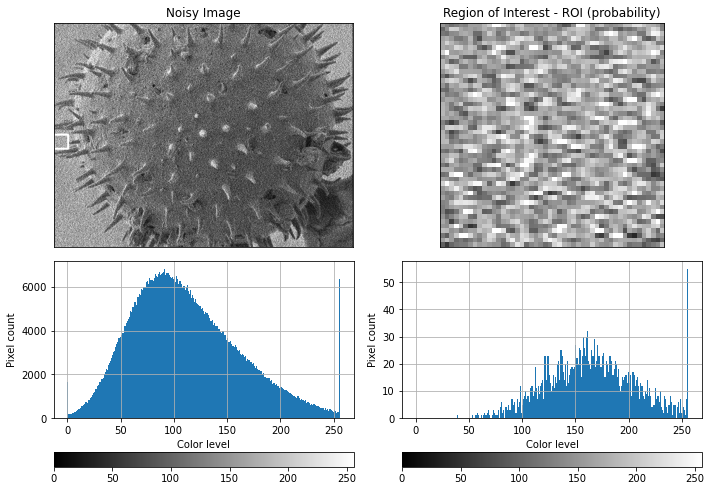

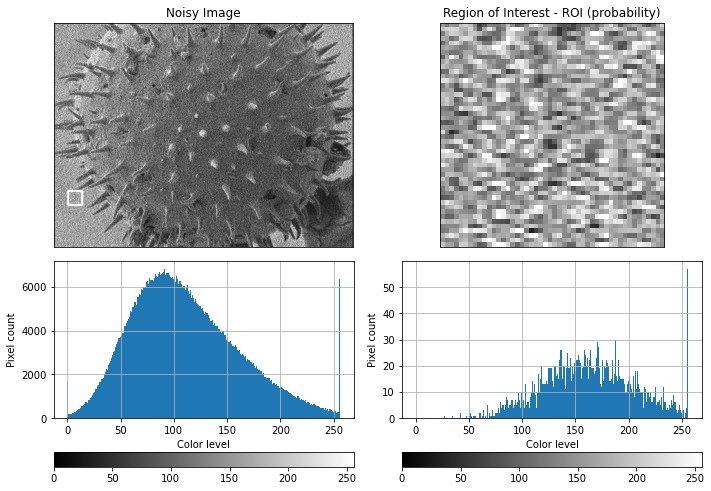

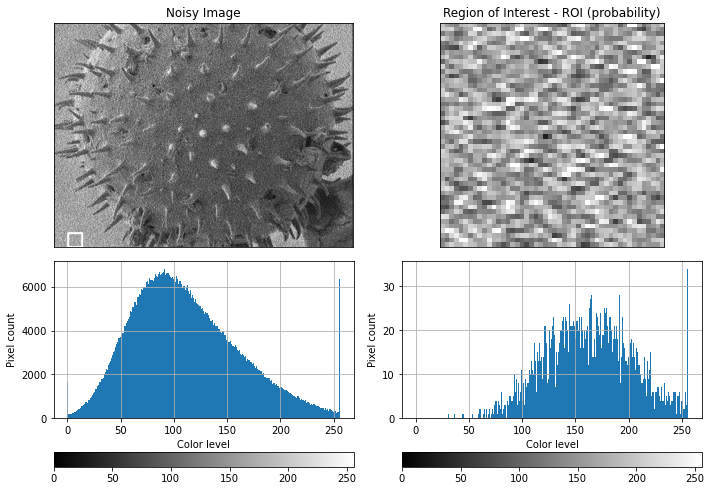

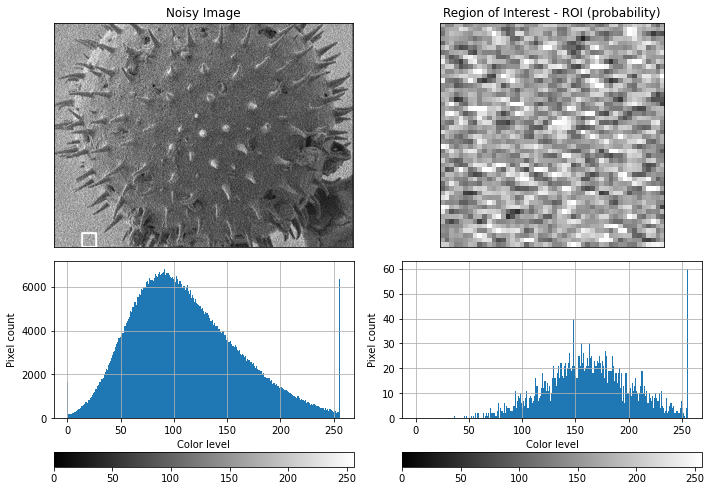

In [16]:
left,upper,right,lower, mean = tile('pollen.spd1.0098.png','SEM','out')
left_select,upper_select,right_select,lower_select = selectROI(left,upper,right,lower, mean)
smooth_parts = visualize_the_ROI('SEM/pollen.spd1.0098.png',left_select,upper_select,right_select,lower_select,'manual_noise/spd01.png')

Selected ROI is smooth_parts[2] . Lets check the histogram and statistical test to be the distribution is normal or gaussian as well as well the resudial calculation.

In [17]:
selected_part = [0,1,8,9]

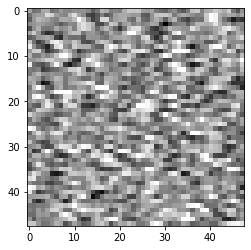

In [19]:
plt.imshow(smooth_parts[9],cmap='gray')

In [20]:
histg = cv2.calcHist([smooth_parts[9]],[0],None,[256],[0,256])

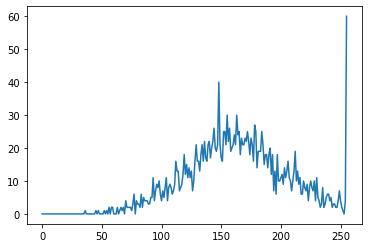

In [21]:
plt.plot(histg)
plt.show()

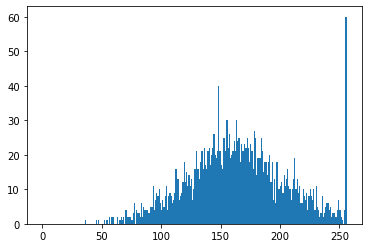

In [22]:
plt.hist(smooth_parts[9].ravel(),256,[0,256])
plt.show()

In [14]:
nb_samples = len(smooth_parts[9].ravel())
nb_samples

2304

--> Anderson-Darling Test
Anderson-Darling Test is a statistical test that can be used to evaluate whether a data sample is in Standard Gaussian Distribution or not.The test is a improved version of nonparametric goodness-of-fit statistical test i.e. Kolmogorov-Smirnov test.
It can be used to check whether a data sample is normal. The test is a modified version of a more sophisticated nonparametric goodness-of-fit statistical test called the Kolmogorov-Smirnov test.
One of the features of Anderson-Darling test is that it returns list of critical value other than single p-value hence it provide us more insights on the final result.
The anderson() SciPy function implements the Anderson-Darling test. It takes as parameters the data sample and the name of the distribution to test it against. By default, the test will check against the Gaussian distribution (dist=’norm’)

In [9]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(smooth_parts[9].ravel())
print('Statistic: %.3f' % result.statistic)
p = 0
print(result.critical_values)
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 2.046
[0.575 0.655 0.786 0.916 1.09 ]
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.916, data does not look normal (reject H0)
1.000: 1.090, data does not look normal (reject H0)


Above code snippets return crtitcal values and statistic values on the sample data. But hold on.... Why we use critical values?

Critical values are basically range of pre-defined significance boundaries at which the H0 can be failed to be rejected if the calculated statistic is less than the critical value.So Anderson-Darling Test return critical values for different significance level instead of single p-value.
Results can be interpreted by failed Null Hypothesis if data is in normal distribution and test statistic value is less than the critical value at choosen significance level.

In [16]:
#!pip install pingouin smooth_parts[2][(smooth_parts[2] > 67) & (smooth_parts[2] < 247)]

In [19]:
smooth_parts[9].ravel()

array([177, 134, 139, ..., 245, 248, 235], dtype=uint8)

Text(0.5, 1.0, 'Square Root Transformed Data')

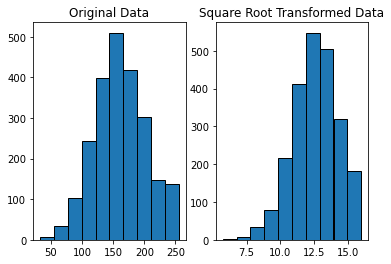

In [111]:
import numpy as np
import matplotlib.pyplot as plt

#make this example reproducible
np.random.seed(0)

#create beta distributed random variable with 200 values
data = smooth_parts[3].ravel()

#create log-transformed data
data_log = np.sqrt(data)

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#create histograms
axs[0].hist(data, edgecolor='black')
axs[1].hist(data_log, edgecolor='black')

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Square Root Transformed Data')

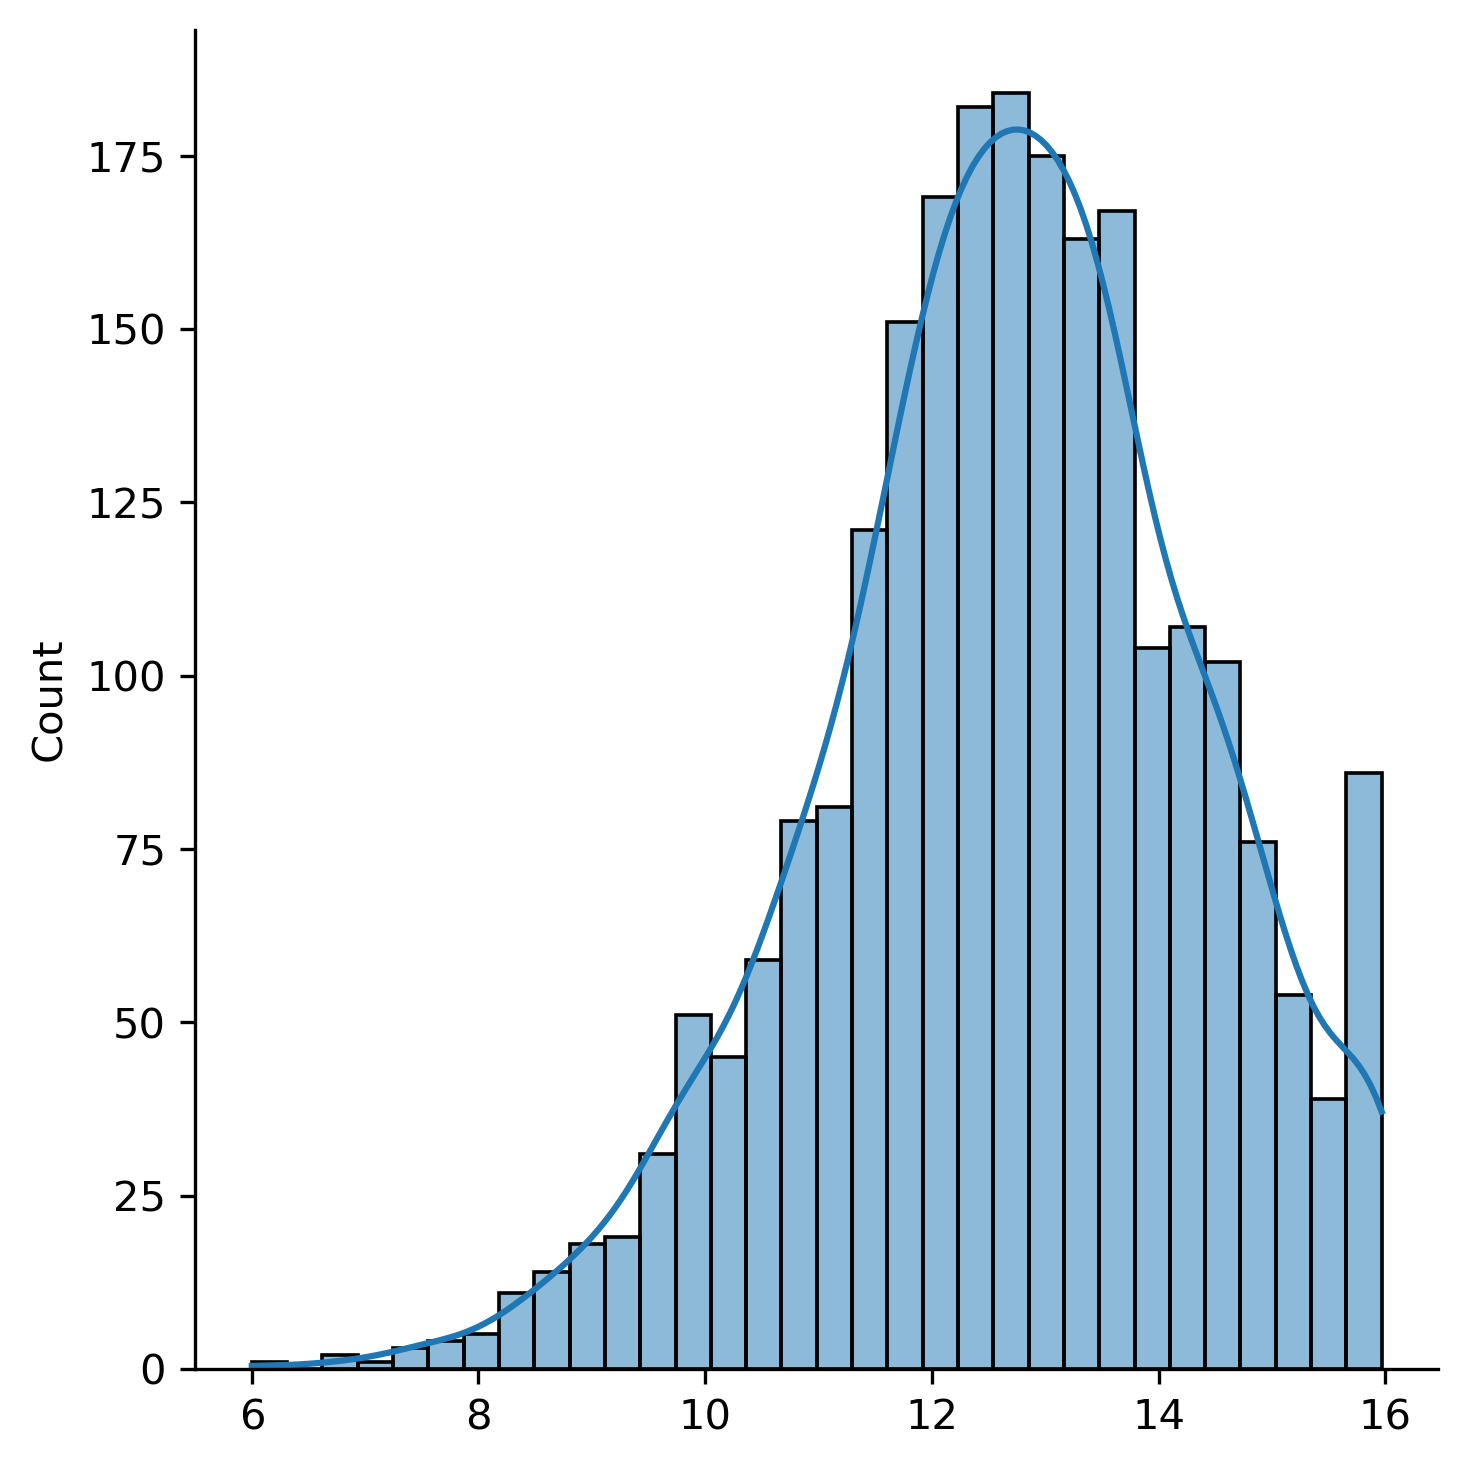

In [21]:
#fig = plt.figure(figsize=(10,6))
p = sns.displot(data_log, kde=True)

p.fig.set_dpi(300)
#plt.savefig('manual_noise/validation/histlog_scan_speed_01.png', dpi=300)

#pg.normality(smooth_parts[9].ravel(),method="jarque_bera")


Text(0.5, 1.0, 'Square Root Transformed Data')

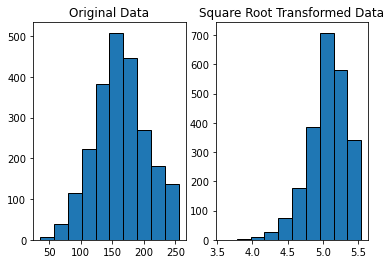

In [16]:
import numpy as np
import matplotlib.pyplot as plt

#make this example reproducible
np.random.seed(0)

#create beta distributed random variable with 200 values
data = smooth_parts[9].ravel()

#create log-transformed data
data_log = np.log(data)

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#create histograms
axs[0].hist(data, edgecolor='black')
axs[1].hist(data_log, edgecolor='black')

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Square Root Transformed Data')

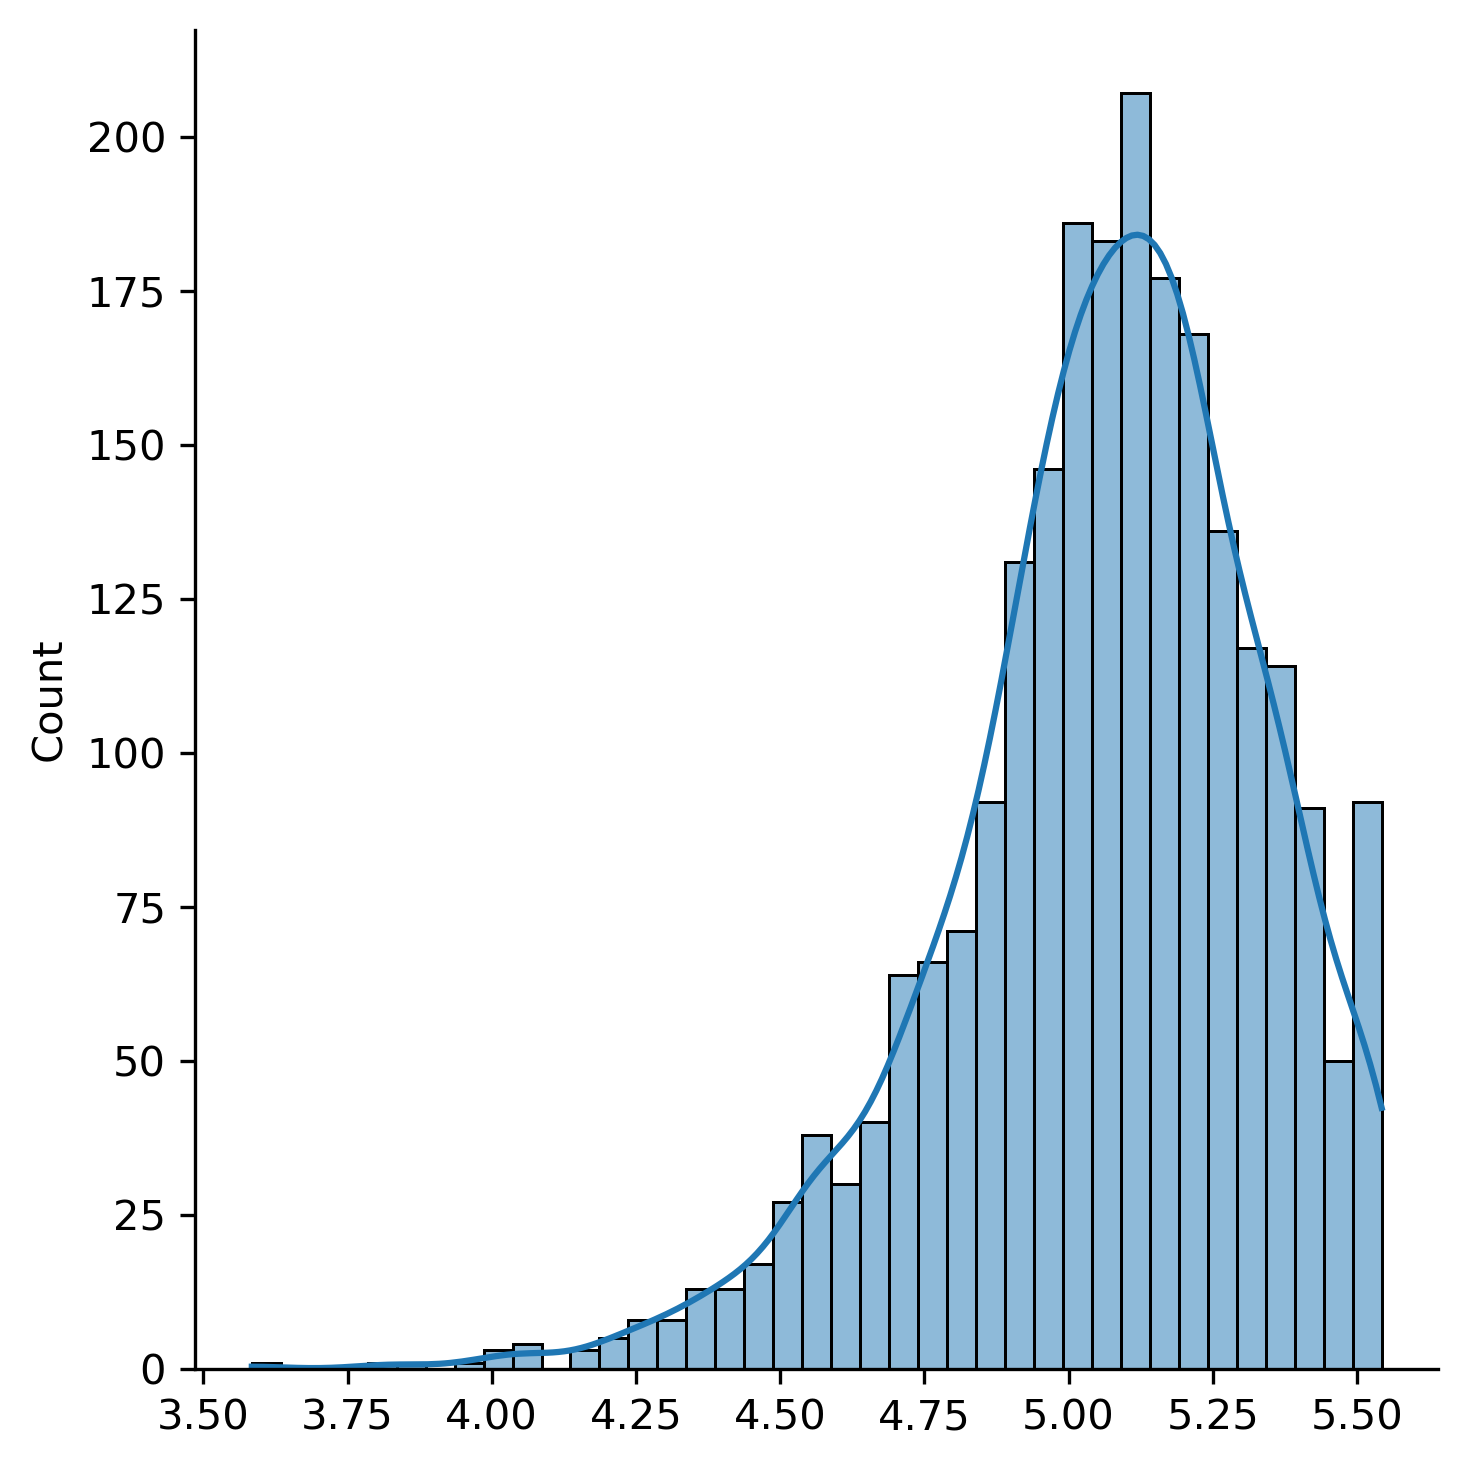

In [20]:
#fig = plt.figure(figsize=(8,5))
p = sns.displot(data_log, kde=True)

p.fig.set_dpi(300)
#plt.savefig('manual_noise/validation/histlog_scan_speed_01.png', dpi=300)

#pg.normality(smooth_parts[9].ravel(),method="jarque_bera")


Text(0.5, 1.0, 'Square Root Transformed Data')

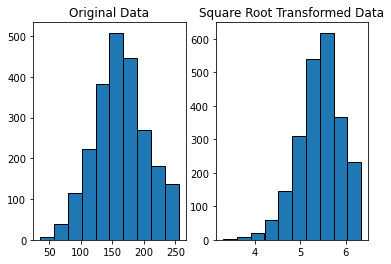

In [24]:
import numpy as np
import matplotlib.pyplot as plt

#make this example reproducible
np.random.seed(0)

#create beta distributed random variable with 200 values
data = smooth_parts[9].ravel()

#create log-transformed data
data_log = np.cbrt(data)

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#create histograms
axs[0].hist(data, edgecolor='black')
axs[1].hist(data_log, edgecolor='black')

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Square Root Transformed Data')

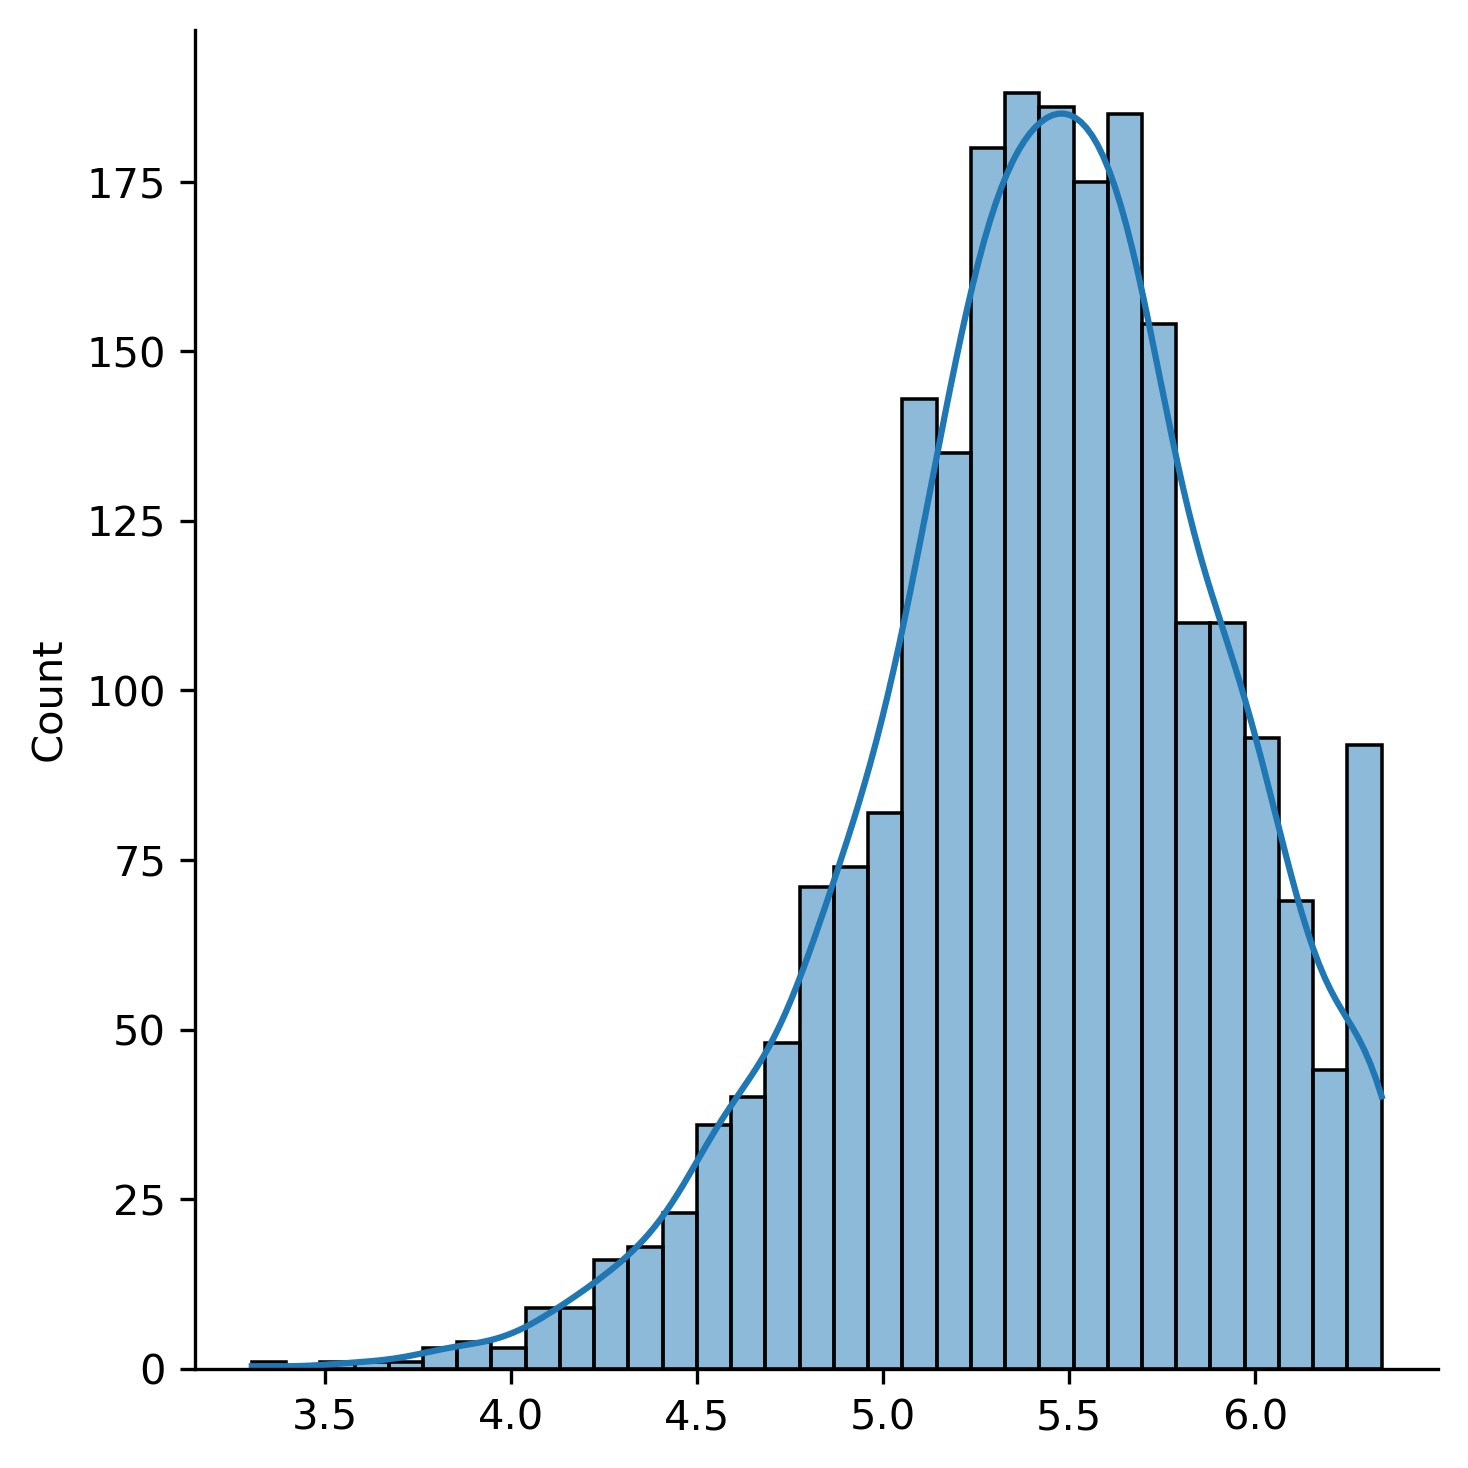

In [25]:
#fig = plt.figure(figsize=(10,6))
p = sns.displot(data_log, kde=True)

p.fig.set_dpi(300)
#plt.savefig('manual_noise/validation/histlog_scan_speed_01.png', dpi=300)

#pg.normality(smooth_parts[9].ravel(),method="jarque_bera")


In [10]:
import pingouin as pg
import seaborn as sns

/home/deepvision/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/deepvision/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [11]:
smooth_parts[9].ravel()[0:100]

array([177, 134, 139, 179, 182, 135, 143, 167, 153, 151, 160, 159, 162,
       152, 118, 137, 190, 182, 144, 151, 145, 185, 207, 204, 206, 171,
       167, 175, 142, 129, 123, 144, 158, 126, 113, 141, 201, 207, 148,
       182, 188, 211, 198, 184, 210, 139, 110, 160, 132, 164, 172, 175,
       226, 214, 172, 157, 150, 195, 225, 176, 153,  96,  87, 110, 143,
       109, 128, 171, 182, 181, 175, 166, 167, 118, 113, 161, 201, 208,
       208, 195, 140, 169, 183, 172, 157, 144, 151, 210, 255, 245, 182,
       168, 183, 176, 157, 177, 116, 167, 193, 183], dtype=uint8)

In [96]:
#suppress warnings
import warnings
warnings.filterwarnings('ignore')
np.exp([177, 134])

array([7.41520730e+76, 1.56841351e+58])

In [97]:
list_data = []
for i in smooth_parts[9].ravel():
    #print(np.exp(i))
    list_data.append(i)
#list_data

In [39]:
len(smooth_parts[9].ravel())

2304

In [31]:
np.flip(smooth_parts[9].ravel())

array([235, 248, 245, ..., 139, 134, 177], dtype=uint8)

In [36]:
np.log(smooth_parts[9].ravel())[0:100]

array([5.176, 4.9  , 4.934, 5.188, 5.203, 4.906, 4.96 , 5.117, 5.03 ,
       5.016, 5.074, 5.07 , 5.086, 5.023, 4.77 , 4.92 , 5.246, 5.203,
       4.97 , 5.016, 4.977, 5.22 , 5.332, 5.316, 5.33 , 5.14 , 5.117,
       5.164, 4.957, 4.86 , 4.812, 4.97 , 5.062, 4.836, 4.727, 4.95 ,
       5.305, 5.332, 4.996, 5.203, 5.24 , 5.35 , 5.29 , 5.215, 5.348,
       4.934, 4.7  , 5.074, 4.883, 5.1  , 5.15 , 5.164, 5.42 , 5.367,
       5.15 , 5.055, 5.01 , 5.273, 5.418, 5.17 , 5.03 , 4.562, 4.465,
       4.7  , 4.96 , 4.69 , 4.85 , 5.14 , 5.203, 5.2  , 5.164, 5.113,
       5.117, 4.77 , 4.727, 5.082, 5.305, 5.336, 5.336, 5.273, 4.94 ,
       5.13 , 5.21 , 5.15 , 5.055, 4.97 , 5.016, 5.348, 5.543, 5.5  ,
       5.203, 5.125, 5.21 , 5.17 , 5.055, 5.176, 4.754, 5.117, 5.26 ,
       5.21 ], dtype=float16)

In [41]:
np.log(np.flip(smooth_parts[9].ravel()))[2204:]

array([5.21 , 5.26 , 5.117, 4.754, 5.176, 5.055, 5.17 , 5.21 , 5.125,
       5.203, 5.5  , 5.543, 5.348, 5.016, 4.97 , 5.055, 5.15 , 5.21 ,
       5.13 , 4.94 , 5.273, 5.336, 5.336, 5.305, 5.082, 4.727, 4.77 ,
       5.117, 5.113, 5.164, 5.2  , 5.203, 5.14 , 4.85 , 4.69 , 4.96 ,
       4.7  , 4.465, 4.562, 5.03 , 5.17 , 5.418, 5.273, 5.01 , 5.055,
       5.15 , 5.367, 5.42 , 5.164, 5.15 , 5.1  , 4.883, 5.074, 4.7  ,
       4.934, 5.348, 5.215, 5.29 , 5.35 , 5.24 , 5.203, 4.996, 5.332,
       5.305, 4.95 , 4.727, 4.836, 5.062, 4.97 , 4.812, 4.86 , 4.957,
       5.164, 5.117, 5.14 , 5.33 , 5.316, 5.332, 5.22 , 4.977, 5.016,
       4.97 , 5.203, 5.246, 4.92 , 4.77 , 5.023, 5.086, 5.07 , 5.074,
       5.016, 5.03 , 5.117, 4.96 , 4.906, 5.203, 5.188, 4.934, 4.9  ,
       5.176], dtype=float16)

Text(0.5, 1.0, 'Flipped Data')

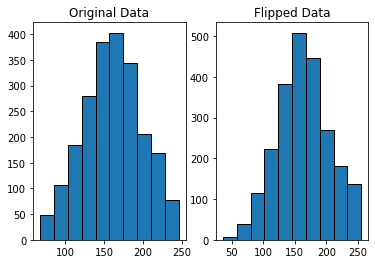

In [25]:
import numpy as np
import matplotlib.pyplot as plt

#make this example reproducible
np.random.seed(0)

#create beta distributed random variable with 200 values
data = smooth_parts[9][(smooth_parts[9] > 67) & (smooth_parts[9] < 247)].ravel()

#create log-transformed data
data_log = np.flip(smooth_parts[9].ravel())

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#create histograms
axs[0].hist(data, edgecolor='black')
axs[1].hist(data_log, edgecolor='black')

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Flipped Data')

In [26]:
from scipy import stats
k2, p = stats.normaltest(data)
#print(p)
alpha = 0.05
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")

else:
    print("The null hypothesis cannot be rejected")
    
if stats.normaltest(np.log(np.flip(smooth_parts[9].ravel())), axis=0).pvalue < alpha:
    print("Not Log-norm")
    print(stats.normaltest(np.log(smooth_parts[9].ravel()), axis=0).pvalue)
else:
    #print(stats.normaltest(np.log(smooth_parts[9].ravel()), axis=0).pvalue)
    print("Log-normal")

p = 3.26064e-08
The null hypothesis can be rejected
Not Log-norm
1.2585707641772582e-53


In [27]:
from scipy import stats
k2, p = stats.normaltest(smooth_parts[9].ravel())
#print(p)
alpha = 0.05
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")

else:
    print("The null hypothesis cannot be rejected")
    
if stats.normaltest(np.exp(smooth_parts[9].ravel()), axis=0).pvalue < alpha:
    print("Not Log-norm")
    print(stats.normaltest(np.exp(smooth_parts[9].ravel()), axis=0).pvalue)
else:
    print("Log-normal")
    
if stats.normaltest(np.exp(np.log(smooth_parts[9].ravel())), axis=0).pvalue < alpha:
    print("Not Multivariate log-normal")
    print(stats.normaltest(np.exp(np.log(smooth_parts[9].ravel())), axis=0).pvalue)
else:
    print("Multivariate log-normal")


p = 0.0108616
The null hypothesis can be rejected
Log-normal
Multivariate log-normal


/tmp/ipykernel_26040/464569810.py:13: RuntimeWarning: overflow encountered in exp
  if stats.normaltest(np.exp(smooth_parts[9].ravel()), axis=0).pvalue < alpha:
/home/deepvision/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:951: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/home/deepvision/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/deepvision/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:961: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/home/deepvision/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  if isinstance(ret, mu.ndarray):
/home/deepvision/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:959: RuntimeWarning: overflow encountered in square
  s = s**2


In [28]:
stats.kstest(smooth_parts[9].ravel(), "lognorm", stats.lognorm.fit(smooth_parts[9].ravel()))

KstestResult(statistic=0.7327133277320304, pvalue=0.0)

In [29]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
data = np.log(smooth_parts[9].ravel())
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.966, p=0.000
Sample does not look Gaussian (reject H0)


In [37]:
from scipy.stats import normaltest
# generate univariate observations
#data = smooth_parts[9].ravel()
# normality test
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Statistics=243.614, p=0.000
Sample does not look Gaussian (reject H0)


In [38]:
# Anderson-Darling Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import anderson
# seed the random number generator
seed(1)
# generate univariate observations
#data = 5 * randn(100) + 50
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 13.250
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.916, data does not look normal (reject H0)
1.000: 1.090, data does not look normal (reject H0)


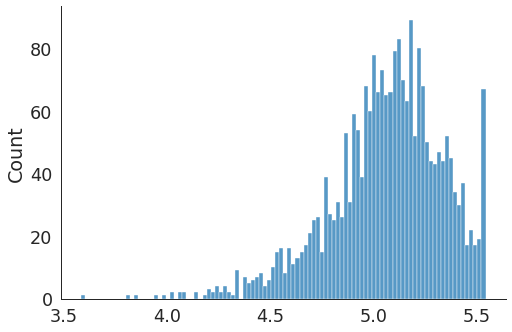

In [30]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=data, kind="hist", bins = 100, aspect = 1.5)

Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 15.46it/s]


sumsquare_error          aic           bic  kl_div  ks_statistic  \
burr            3.379841   411.462299 -15001.647105     inf      0.029777   
beta            4.065505   409.005102 -14576.077000     inf      0.070251   
norm            4.437020   682.646692 -14390.088917     inf      0.059186   
gamma          16.391618   309.110799 -11371.508684     inf      0.178950   
lognorm        17.381596  1603.245603 -11236.397949     inf      0.238710   

             ks_pvalue  
burr      3.294300e-02  
beta      2.479428e-10  
norm      1.857054e-07  
gamma     5.071037e-65  
lognorm  5.217671e-116

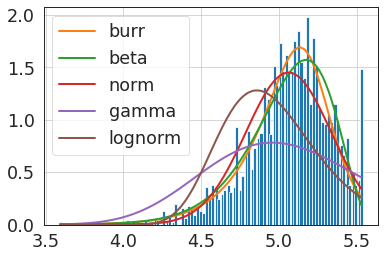

In [31]:
f = Fitter(data,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [32]:
f.get_best(method = 'sumsquare_error')

{'burr': {'c': 48.483563520828206,
  'd': 0.4720050442179906,
  'loc': -0.23248289440152575,
  'scale': 5.459061199299216}}

In [33]:
f.fitted_param["burr"]

(48.483563520828206,
 0.4720050442179906,
 -0.23248289440152575,
 5.459061199299216)

Fitting 10 distributions: 100%|█████████████████| 10/10 [00:00<00:00, 39.25it/s]


sumsquare_error          aic           bic    kl_div  ks_statistic  \
norm             4.437020   682.646692 -14390.088917       inf      0.059186   
cauchy           6.034600   351.506963 -13681.547449       inf      0.107977   
chi2             6.557552  1269.696998 -13482.324733       inf      0.090749   
rayleigh         7.557701          inf -13163.015048  0.151737      0.086186   
powerlaw        16.143170   312.750691 -11406.697788       inf      0.181563   

             ks_pvalue  
norm      1.857054e-07  
cauchy    7.561160e-24  
chi2      5.822314e-17  
rayleigh  2.441911e-15  
powerlaw  6.193277e-67

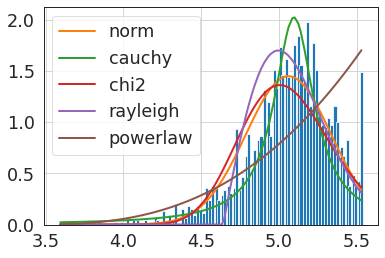

In [34]:
f = Fitter(data,
           distributions= get_common_distributions())
f.fit()
f.summary()

In [36]:
f.get_best(method = 'sumsquare_error')

{'norm': {'loc': 5.062, 'scale': 0.275}}

In [ ]:
#get_distributions()

Fitting 106 distributions:  67%|██████████     | 71/106 [00:34<00:39,  1.13s/it]SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED johnsonsb distribution (taking more than 30 seconds)
Fitting 106 distributions:  70%|██████████▍    | 74/106 [00:34<00:17,  1.80it/s]SKIPPED kappa4 distribution (taking more than 30 seconds)
SKIPPED ksone distribution (taking more than 30 seconds)
Fitting 106 distributions:  73%|██████████▉    | 77/106 [00:35<00:11,  2.53it/s]/home/deepvision/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose in

sumsquare_error         aic           bic  kl_div  ks_statistic  \
burr                3.379841  411.462299 -15001.647105     inf      0.029777   
powernorm           3.433817  544.498902 -14972.885463     inf      0.026589   
hypsecant           3.505954  463.285064 -14932.727325     inf      0.052547   
genlogistic         3.517723  397.174359 -14917.263498     inf      0.025381   
tukeylambda         3.682550  473.048654 -14811.760372     inf      0.046878   

             ks_pvalue  
burr          0.032943  
powernorm     0.075583  
hypsecant     0.000006  
genlogistic   0.101012  
tukeylambda   0.000077

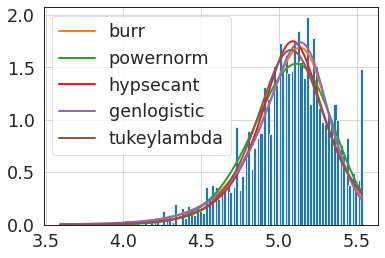

In [37]:
f = Fitter(data,
           distributions= get_distributions())
f.fit()
f.summary()

In [38]:
f.get_best(method = 'sumsquare_error')

{'burr': {'c': 48.483563520828206,
  'd': 0.4720050442179906,
  'loc': -0.23248289440152575,
  'scale': 5.459061199299216}}

In [71]:
stats.normaltest(np.log(smooth_parts[9].ravel()), axis=0)

NormaltestResult(statistic=243.61406633137454, pvalue=1.2585707641772582e-53)

In [41]:
len(smooth_parts[9])

48

In [32]:
smooth_parts[9][(smooth_parts[9] > 67) & (smooth_parts[9] < 247)]

array([177, 134, 139, ..., 235, 245, 235], dtype=uint8)

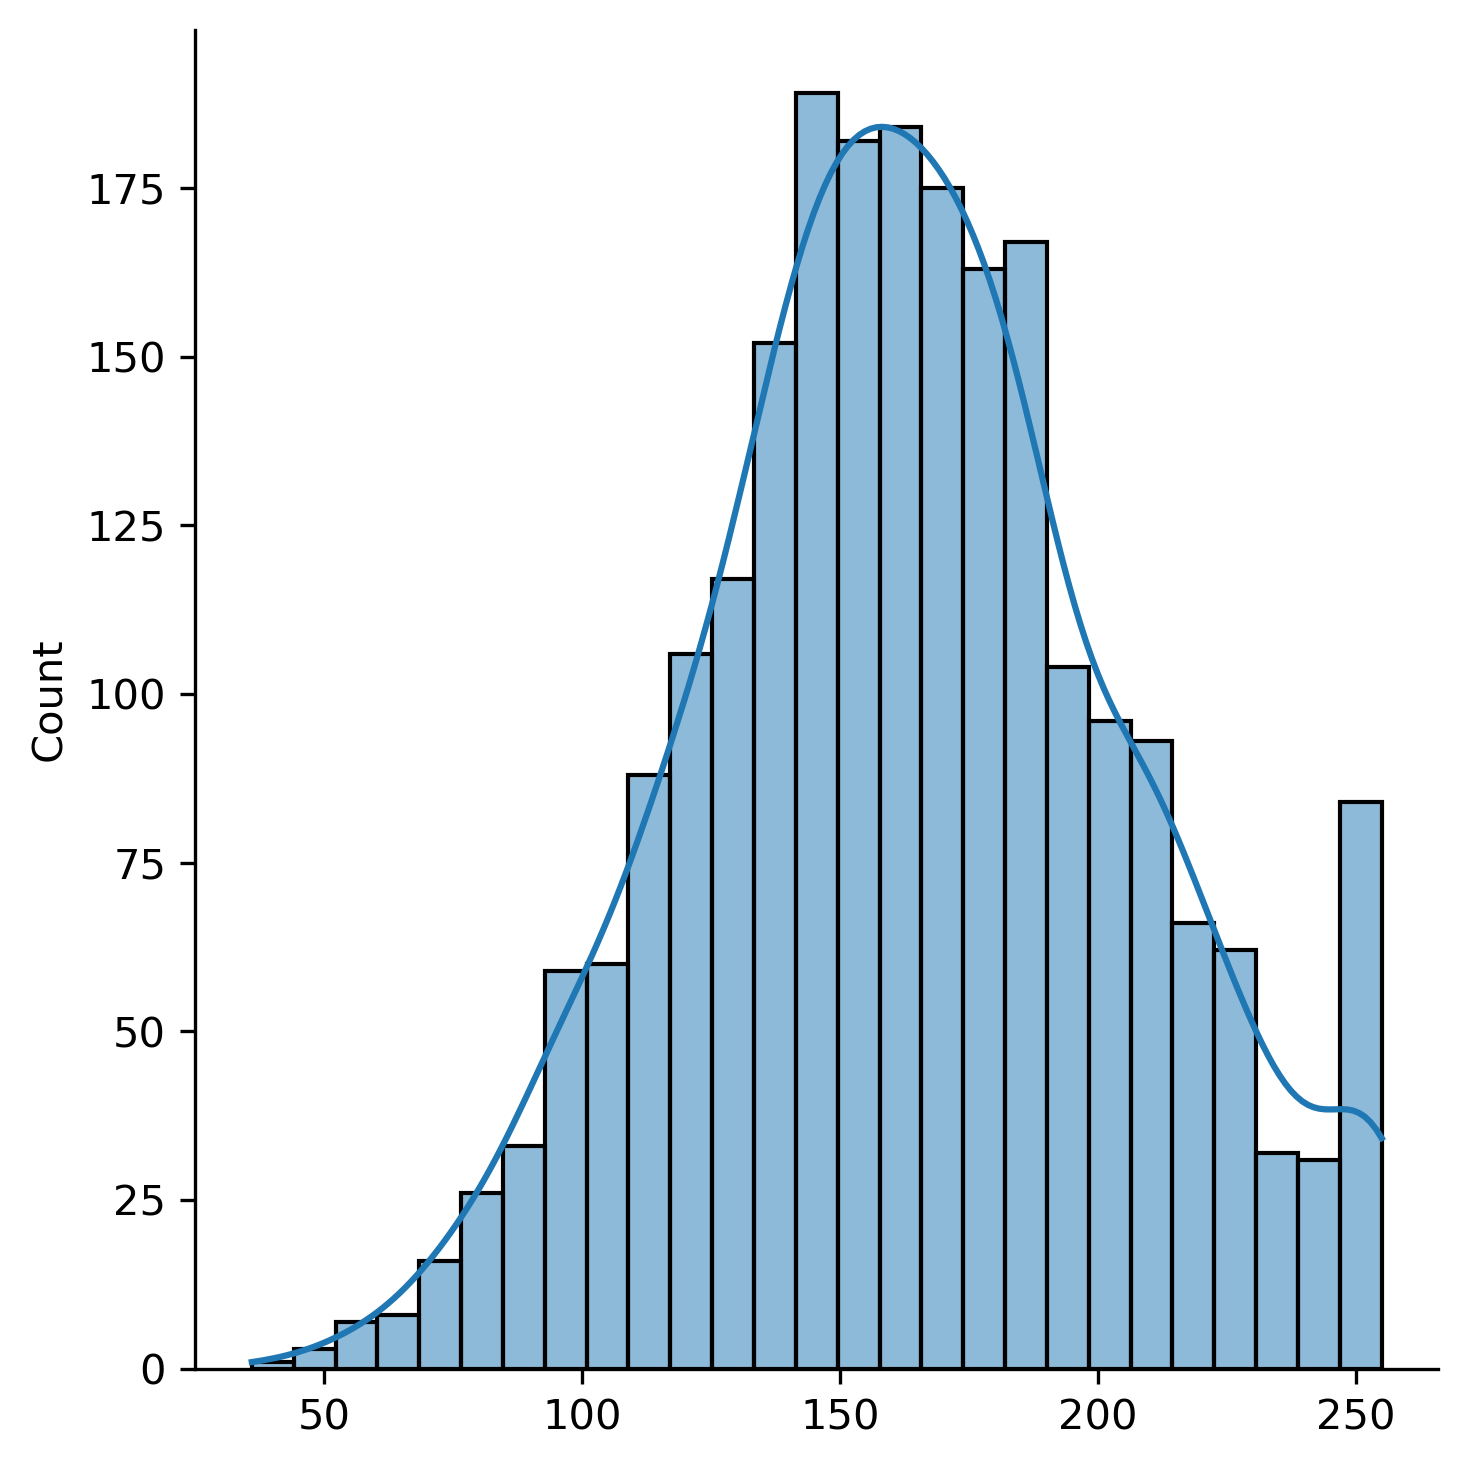

In [13]:
#fig = plt.figure(figsize=(10,6))
p = sns.displot(smooth_parts[9].ravel(), kde=True)

p.fig.set_dpi(300)
plt.savefig('manual_noise/validation/histlog_scan_speed_01.png', dpi=300)

#pg.normality(smooth_parts[9].ravel(),method="jarque_bera")


In [141]:
pg.normality(smooth_parts[1].ravel(),method="jarque_bera")

W     pval  normal
0  3.489483  0.17469    True

In [142]:
smooth_parts[1].ravel()

array([195, 167, 192, ...,  10,  40,  57], dtype=uint8)

In [143]:
#(df, alpha=.05)
pg.multivariate_normality(smooth_parts[1],alpha=.05)

HZResults(hz=192, pval=0.0, normal=False)

In [18]:
import scipy
from scipy.stats import lognorm

shape, location, scale = scipy.stats.lognorm.fit(smooth_parts[9].ravel())
mu, sigma = np.log(scale), shape

In [22]:
mu

1.382308801004812

Many statistical tests make the assumption that datasets are normally distributed.

There are 2 common ways to check this assumption in Python:

# 1. (Visual Method) Create a histogram.

If the histogram is roughly “bell-shaped”, then the data is assumed to be normally distributed.

# 2. (Formal Statistical Test) Perform a Shapiro-Wilk Test.

If the p-value of the test is greater than α = .001, then the data is assumed to be normally distributed.



(array([  2.,   5.,   6.,  12.,  21.,  24.,  51.,  96., 142., 206., 234.,
        246., 262., 234., 203., 160., 160.,  96.,  56.,  88.]),
 array([ 10.  ,  22.25,  34.5 ,  46.75,  59.  ,  71.25,  83.5 ,  95.75,
        108.  , 120.25, 132.5 , 144.75, 157.  , 169.25, 181.5 , 193.75,
        206.  , 218.25, 230.5 , 242.75, 255.  ]),
 <BarContainer object of 20 artists>)

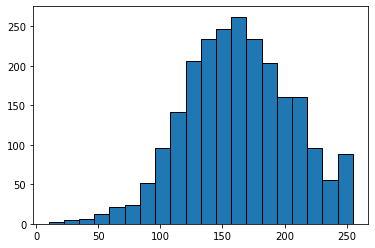

In [144]:
# Visual method
#make this example reproducible
np.random.seed(1)

#create histogram to visualize values in dataset
plt.hist(smooth_parts[1].ravel(), edgecolor='black', bins=20)

By simply looking at this histogram, we can tell the dataset does not exhibit a “bell-shape” and is not normally distributed.

In [145]:
#Perform a Shapiro-Wilk Test

#make this example reproducible
np.random.seed(1)


#perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(smooth_parts[1].ravel())
alpha = 0.05
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 2.29572e-07
The null hypothesis can be rejected


From the output we can see that the test statistic is 0.99 and the corresponding p-value is 2.8438714494427586e-08 (extremely close to zero).

Since the p-value is less than 0.001, we reject the null hypothesis of the Shapiro-Wilk test.

This means we have sufficient evidence to say that the sample data does not come from a normal distribution.

# Residual Calculation Test

In [146]:
#Residual Calculation Test
meangauss, sigmagauss, residialgauss = computeresidualgaussian(smooth_parts[1].ravel())

In [147]:
print(meangauss)
print(sigmagauss)

255
19.14922888857728


In [148]:
residialgauss

array([0.00687682, 0.00687682, 0.00687682, ..., 0.05127571, 0.00388081,
       0.00647327])

In [149]:
meanpois, sigmapois, residialpois = computeresidualpoisson(smooth_parts[1].ravel())

In [150]:
print(meanpois)
print(sigmapois)

255
15.968719422671311


In [151]:
residialpois

array([0.00685128, 0.00687681, 0.00686556, ..., 0.00687682, 0.00687682,
       0.00687682])

In [152]:
type_noise = []
gauss = []
poi = []
for i in range(0,len(residialgauss)):
    #for j in residialpois:
    if (residialgauss[i] - 0) > (residialpois[i]-0):
        type_noise.append('poison')
        poi.append(residialpois[i])
    else:
        type_noise.append('gaussian')
        gauss.append(residialgauss[i])
print('Poison pixels : ', str(type_noise.count('poison')))
print('Gaussian pixels : ', str(type_noise.count('gaussian')))

Poison pixels :  1428
Gaussian pixels :  876


In [294]:
#plt.hist(smooth_parts[2].ravel(), edgecolor='black', bins=20)

# Segmentation and Noise Estimation Scan speed 02

48


/tmp/ipykernel_2240/1017964780.py:48: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')
/tmp/ipykernel_2240/1017964780.py:57: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')


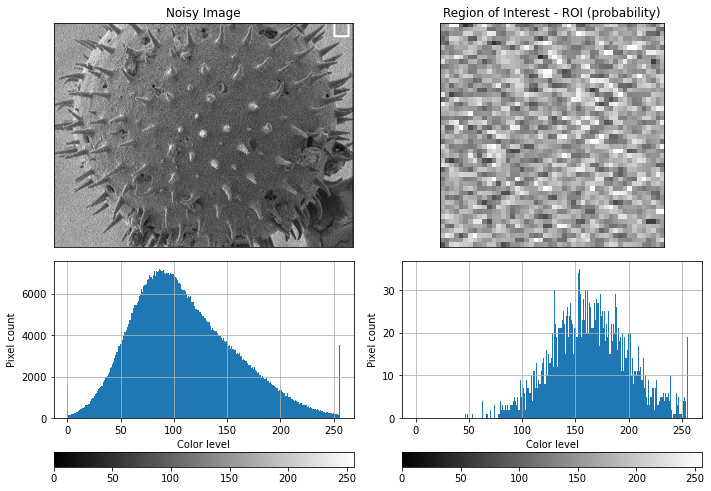

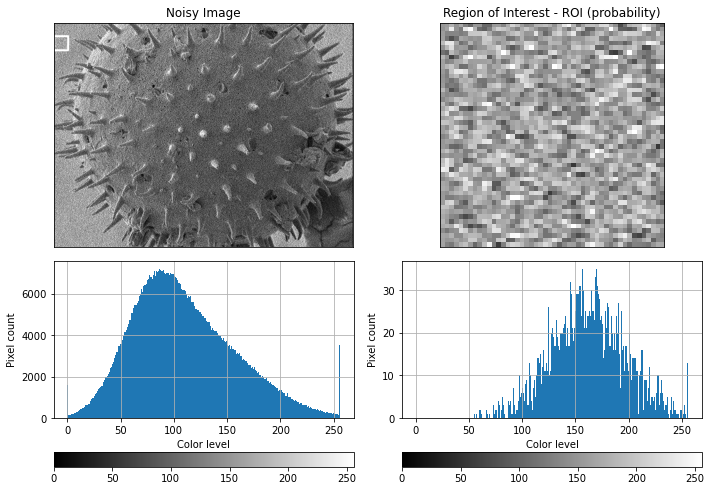

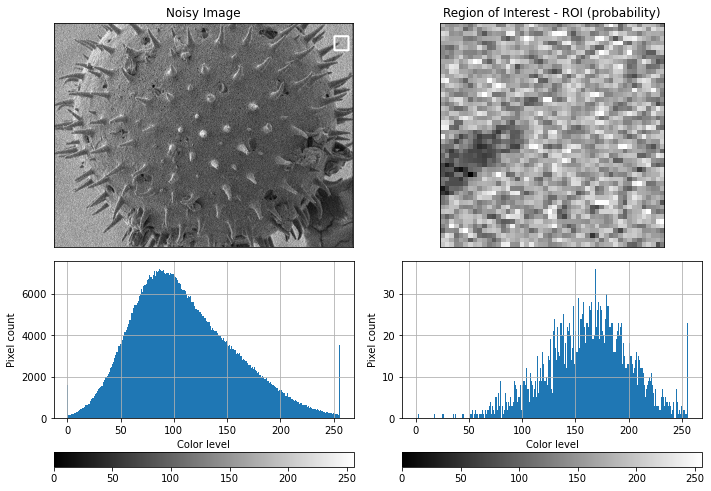

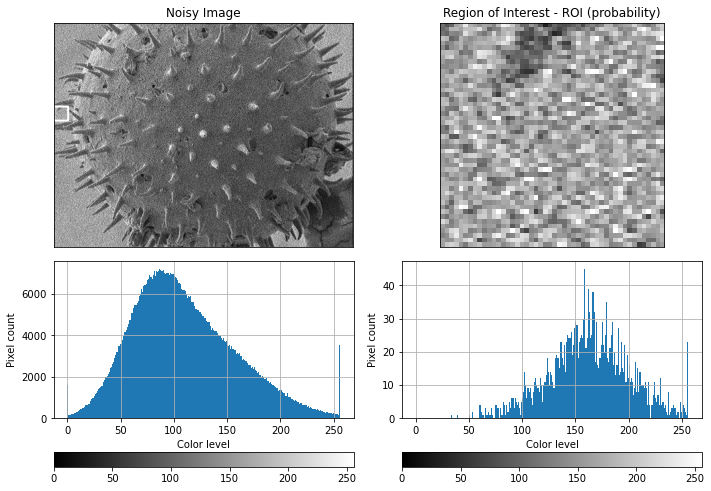

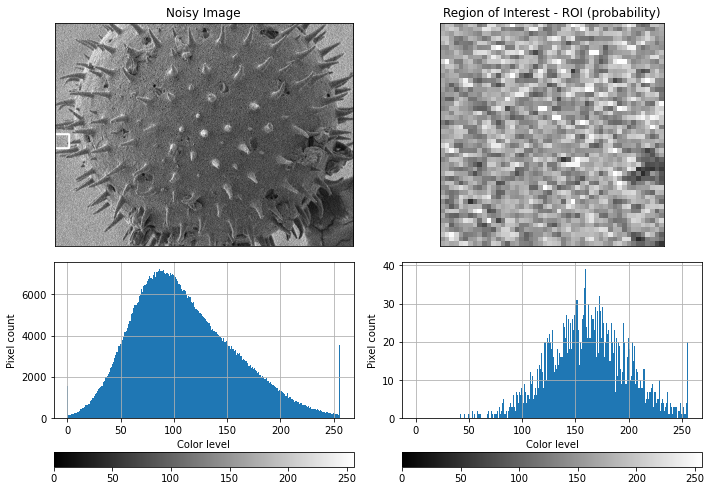

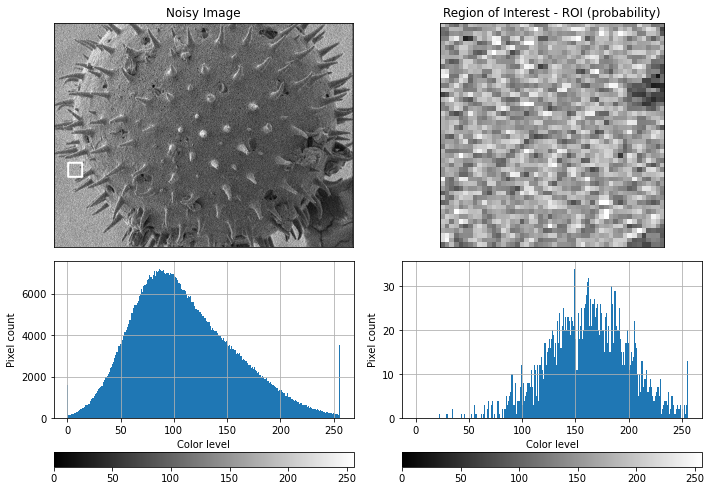

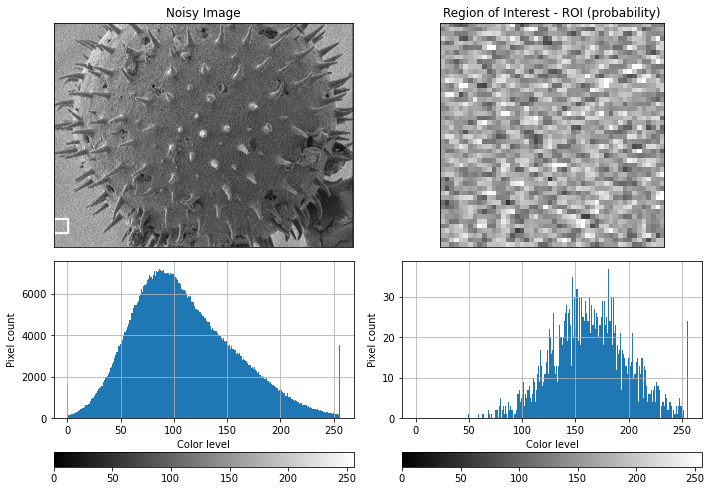

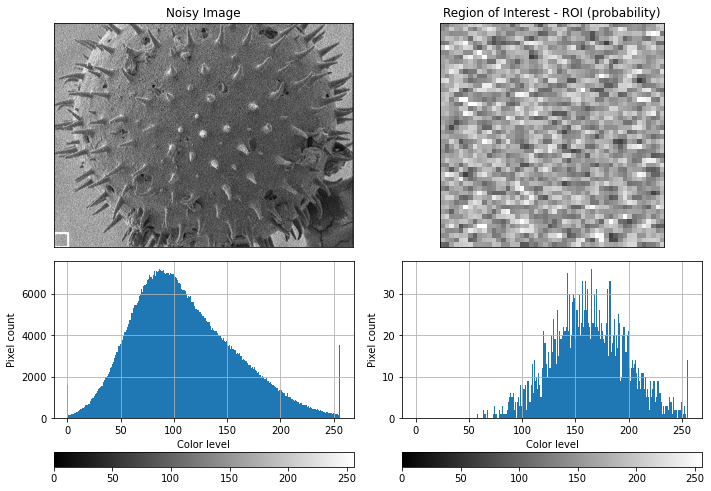

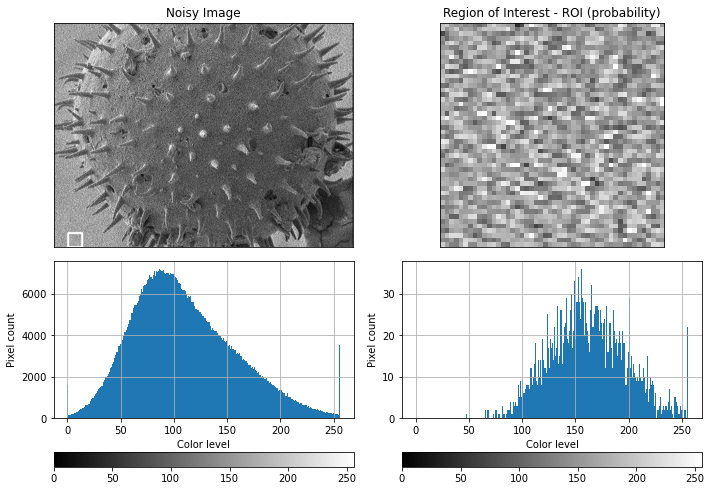

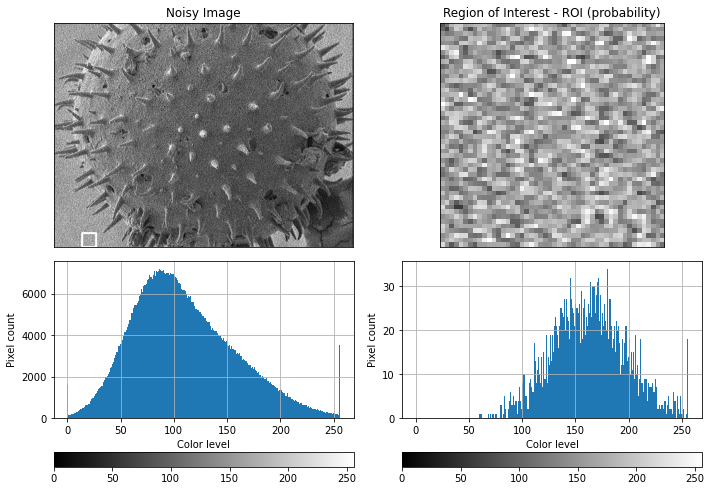

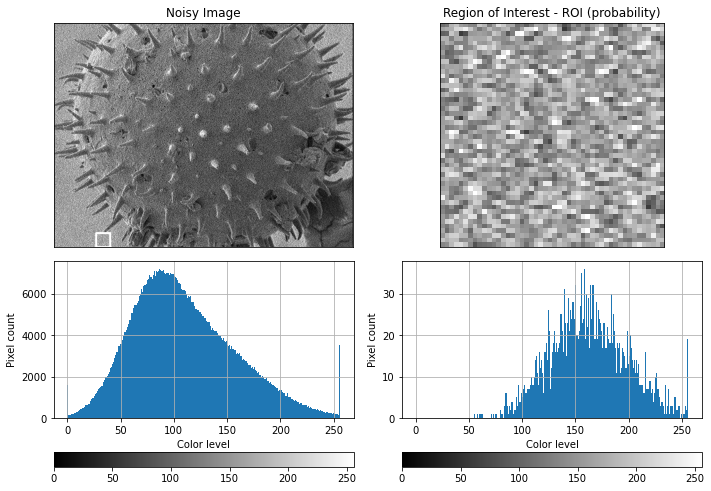

In [343]:
left,upper,right,lower, mean = tile('pollen.spd2.0098.png','SEM','out')
left_select,upper_select,right_select,lower_select = selectROI(left,upper,right,lower, mean)
smooth_parts = visualize_the_ROI('SEM/pollen.spd2.0098.png',left_select,upper_select,right_select,lower_select,'manual_noise/spd02.png')

In [344]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(smooth_parts[1].ravel())
print('Statistic: %.3f' % result.statistic)
p = 0
print(result.critical_values)
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 0.363
[0.575 0.655 0.786 0.916 1.09 ]
15.000: 0.575, data looks normal (fail to reject H0)
10.000: 0.655, data looks normal (fail to reject H0)
5.000: 0.786, data looks normal (fail to reject H0)
2.500: 0.916, data looks normal (fail to reject H0)
1.000: 1.090, data looks normal (fail to reject H0)


In [345]:
from scipy import stats
k2, p = stats.normaltest(smooth_parts[1].ravel())
#print(p)
alpha = 0.001
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.508325
The null hypothesis cannot be rejected


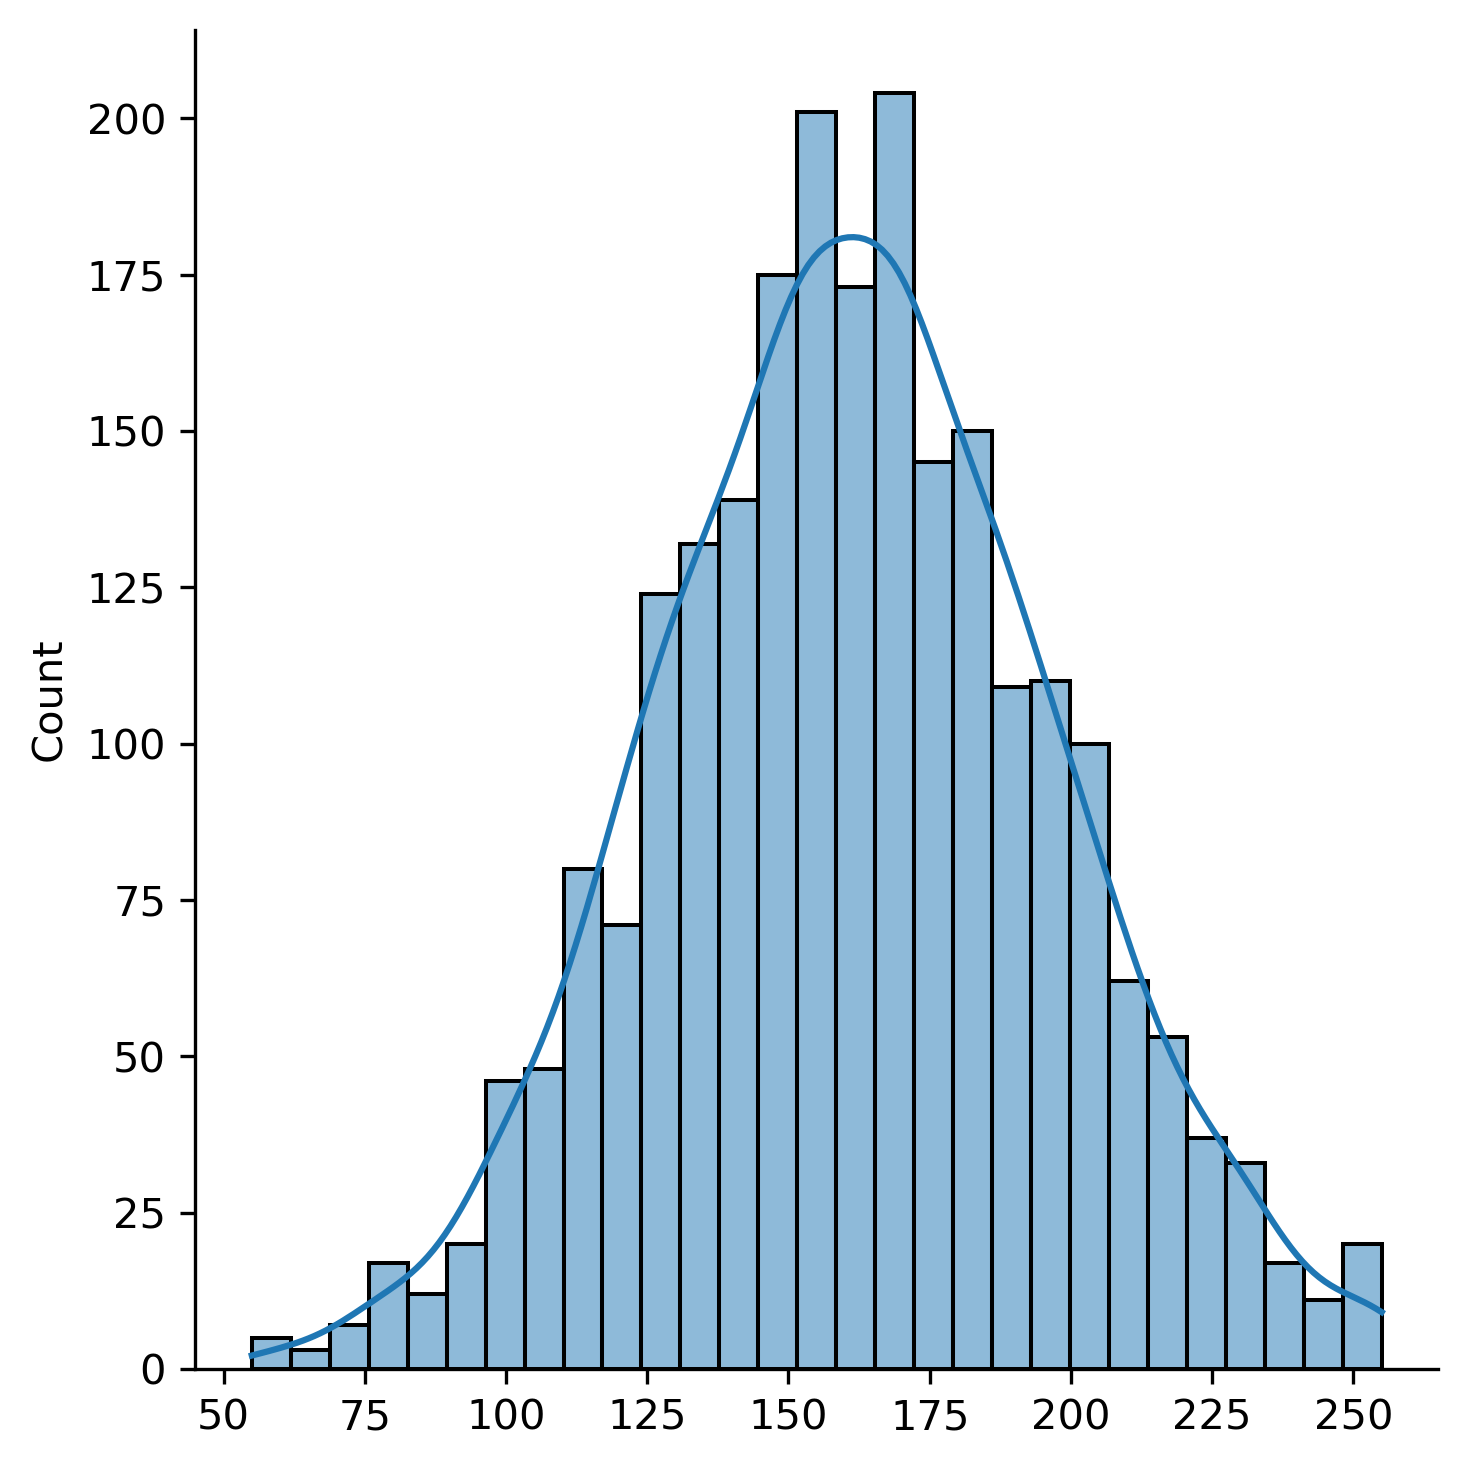

In [346]:
p = sns.displot(smooth_parts[1].ravel(), kde=True)

p.fig.set_dpi(300)
plt.savefig('manual_noise/validation/hist_scan_speed_02.png', dpi=300)


In [347]:
pg.normality(smooth_parts[1].ravel(),method="jarque_bera")

W      pval  normal
0  1.393262  0.498261    True

(array([  5.,   8.,  20.,  25.,  61.,  77., 139., 174., 195., 266., 253.,
        281., 212., 186., 141.,  99.,  63.,  51.,  24.,  24.]),
 array([ 55.,  65.,  75.,  85.,  95., 105., 115., 125., 135., 145., 155.,
        165., 175., 185., 195., 205., 215., 225., 235., 245., 255.]),
 <BarContainer object of 20 artists>)

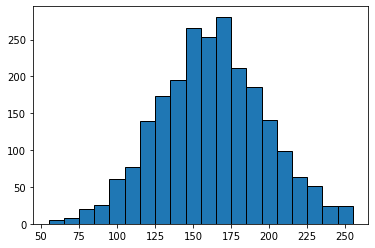

In [348]:
# Visual method
#make this example reproducible
np.random.seed(1)

#create histogram to visualize values in dataset
plt.hist(smooth_parts[1].ravel(), edgecolor='black', bins=20)

In [349]:
#Perform a Shapiro-Wilk Test

#make this example reproducible
np.random.seed(1)


#perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(smooth_parts[1].ravel())
alpha = 0.001
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.0476913
The null hypothesis cannot be rejected


# Residual Calculation Test

In [350]:
meangauss, sigmagauss, residialgauss = computeresidualgaussian(smooth_parts[1].ravel())
residialgauss

array([0.00849877, 0.00849877, 0.01616978, ..., 0.00849877, 0.02496689,
       0.02866519])

In [351]:
meanpois, sigmapois, residialpois = computeresidualpoisson(smooth_parts[1].ravel())
residialpois

array([0.17551144, 0.20286303, 0.0066487 , ..., 0.14934788, 0.03647423,
       0.06681537])

In [352]:
type_noise = []
gauss = []
poi = []
for i in range(0,len(residialgauss)):
    #for j in residialpois:
    if (residialgauss[i] - 0) > (residialpois[i]-0):
        type_noise.append('poison')
        poi.append(residialpois[i])
    else:
        type_noise.append('gaussian')
        gauss.append(residialgauss[i])
print('Poison pixels : ', str(type_noise.count('poison')))
print('Gaussian pixels : ', str(type_noise.count('gaussian')))

Poison pixels :  838
Gaussian pixels :  1466


In [353]:
#!pip install poisson-etest

# Segmentation and Noise Estimation Scan speed 03

48


/tmp/ipykernel_2240/1017964780.py:48: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')
/tmp/ipykernel_2240/1017964780.py:57: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')


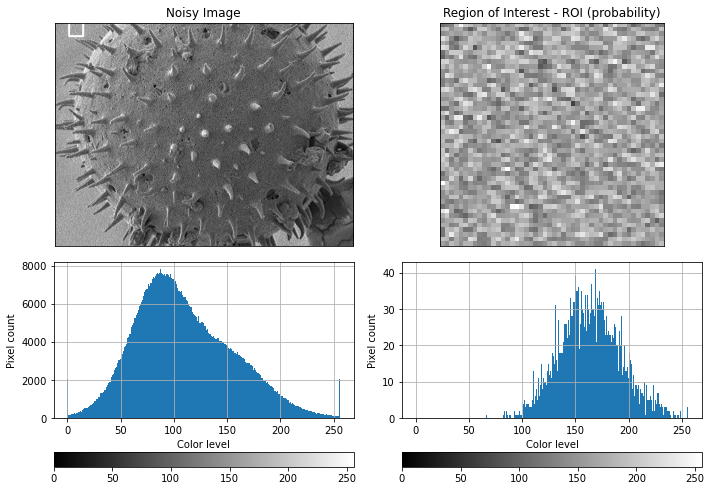

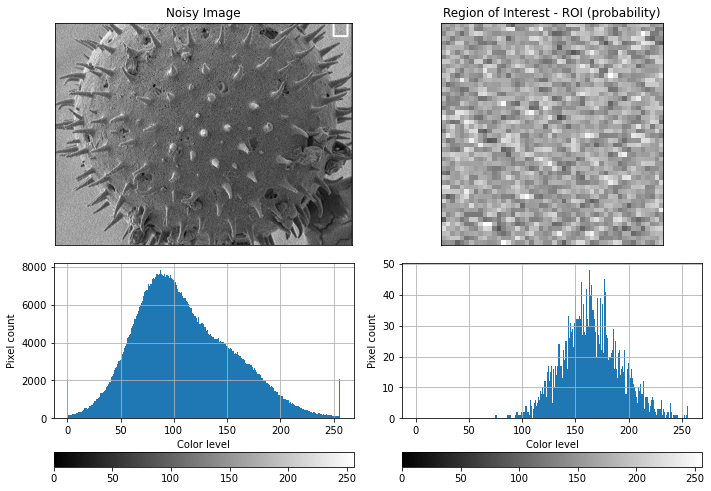

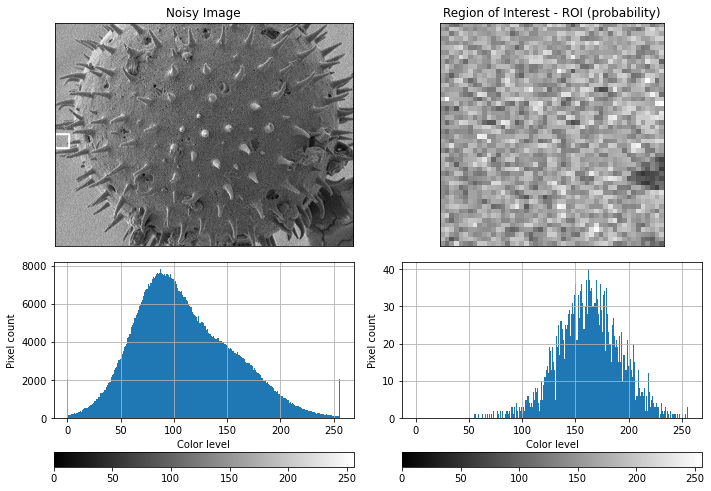

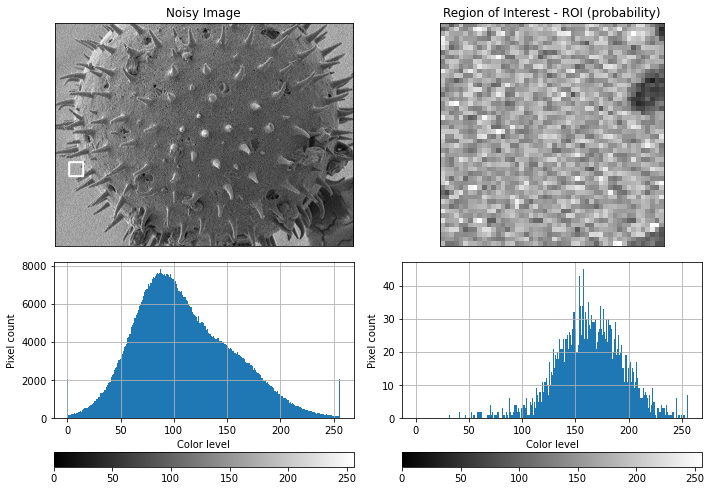

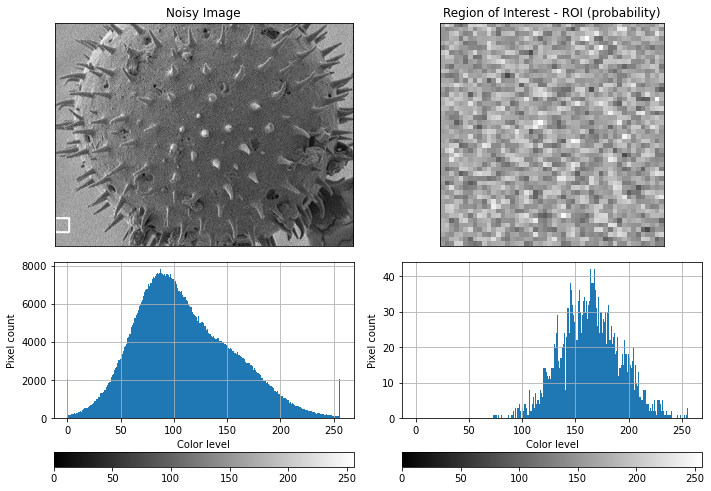

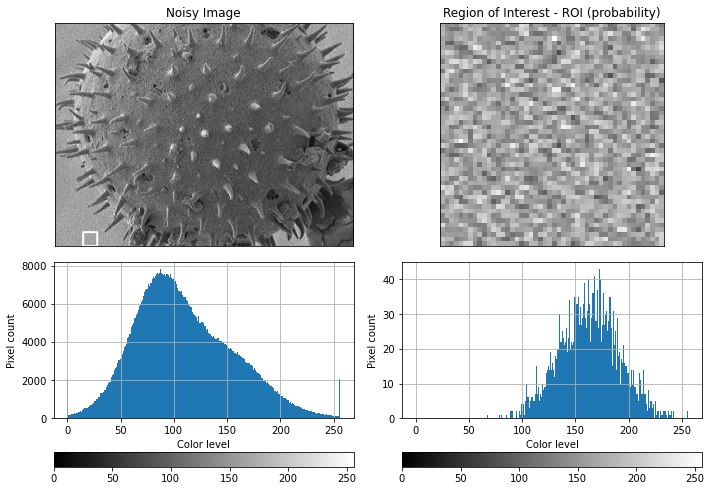

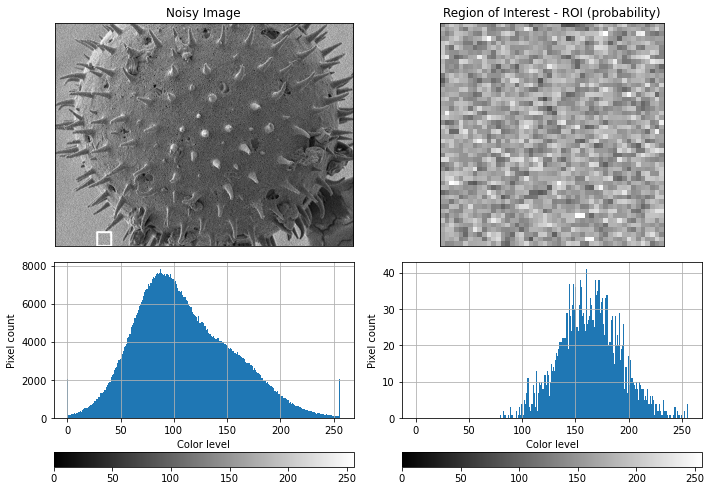

In [354]:
left,upper,right,lower, mean = tile('pollen.spd3.0098.png','SEM','out')
left_select,upper_select,right_select,lower_select = selectROI(left,upper,right,lower, mean)
smooth_parts = visualize_the_ROI('SEM/pollen.spd3.0098.png',left_select,upper_select,right_select,lower_select,'manual_noise/spd03.png')

In [355]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(smooth_parts[5].ravel())
print('Statistic: %.3f' % result.statistic)
p = 0
print(result.critical_values)
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 0.396
[0.575 0.655 0.786 0.916 1.09 ]
15.000: 0.575, data looks normal (fail to reject H0)
10.000: 0.655, data looks normal (fail to reject H0)
5.000: 0.786, data looks normal (fail to reject H0)
2.500: 0.916, data looks normal (fail to reject H0)
1.000: 1.090, data looks normal (fail to reject H0)


In [356]:
from scipy import stats
k2, p = stats.normaltest(smooth_parts[5].ravel())
#print(p)
alpha = 0.05
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.31443
The null hypothesis cannot be rejected


W      pval  normal
0  2.219438  0.329652    True

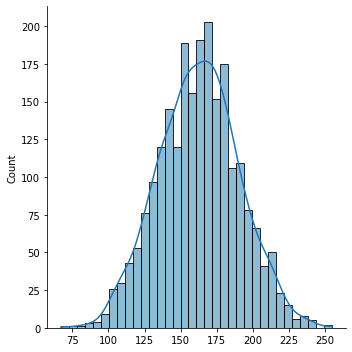

In [357]:
sns.displot(smooth_parts[5].ravel(), kde=True)
pg.normality(smooth_parts[5].ravel(),method="jarque_bera")

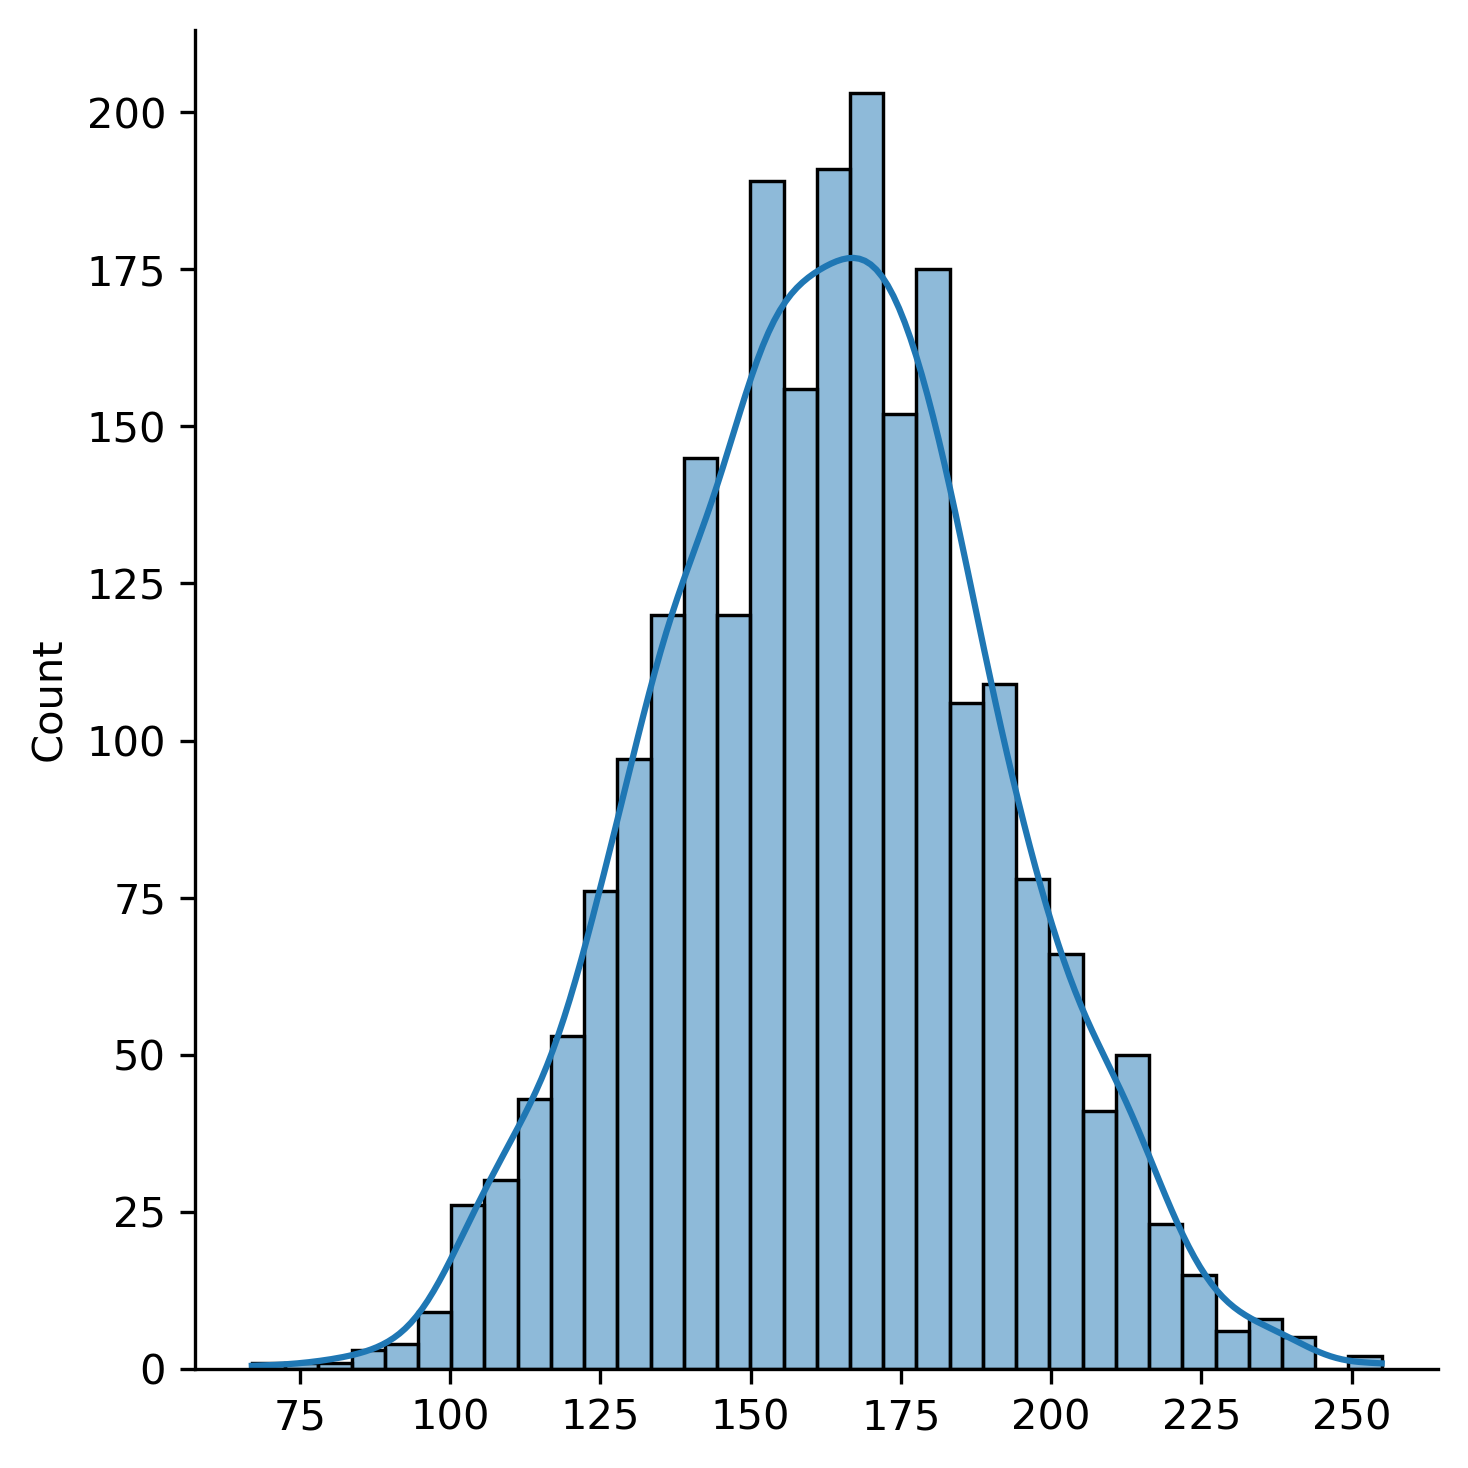

In [360]:
p = sns.displot(smooth_parts[5].ravel(), kde=True)
p.fig.set_dpi(300)
plt.savefig('manual_noise/validation/hist_scan_speed_03.png', dpi=300)


(array([  1.,   3.,   6.,  29.,  58.,  88., 139., 228., 245., 277., 325.,
        282., 249., 145.,  95.,  77.,  34.,  13.,   8.,   2.]),
 array([ 67. ,  76.4,  85.8,  95.2, 104.6, 114. , 123.4, 132.8, 142.2,
        151.6, 161. , 170.4, 179.8, 189.2, 198.6, 208. , 217.4, 226.8,
        236.2, 245.6, 255. ]),
 <BarContainer object of 20 artists>)

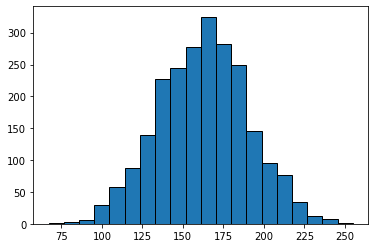

In [361]:
# Visual method
#make this example reproducible
np.random.seed(1)

#create histogram to visualize values in dataset
plt.hist(smooth_parts[5].ravel(), edgecolor='black', bins=20)

In [362]:
#Perform a Shapiro-Wilk Test

#make this example reproducible
np.random.seed(1)


#perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(smooth_parts[5].ravel())
alpha = 0.001
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.369518
The null hypothesis cannot be rejected


# Residual Calculation Test

In [363]:
meangauss, sigmagauss, residialgauss = computeresidualgaussian(smooth_parts[5].ravel())
residialgauss

array([0.010515  , 0.010515  , 0.010515  , ..., 0.010515  , 0.06073947,
       0.00772478])

In [364]:
meanpois, sigmapois, residialpois = computeresidualpoisson(smooth_parts[5].ravel())
residialpois

array([0.17664056, 0.00888905, 0.00729988, ..., 0.00917642, 0.1767063 ,
       0.00786635])

In [365]:
type_noise = []
gauss = []
poi = []
for i in range(0,len(residialgauss)):
    #for j in residialpois:
    if (residialgauss[i] - 0) > (residialpois[i]-0):
        type_noise.append('poison')
        poi.append(residialpois[i])
    else:
        type_noise.append('gaussian')
        gauss.append(residialgauss[i])
print('Poison pixels : ', str(type_noise.count('poison')))
print('Gaussian pixels : ', str(type_noise.count('gaussian')))

Poison pixels :  991
Gaussian pixels :  1313


In [366]:
print(np.mean(gauss))
print(np.mean(poi))

0.025124726930250786
0.009925176555051395


# Segmentation and Noise Estimation Scan speed 05

48


/tmp/ipykernel_2240/1017964780.py:48: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')
/tmp/ipykernel_2240/1017964780.py:57: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')


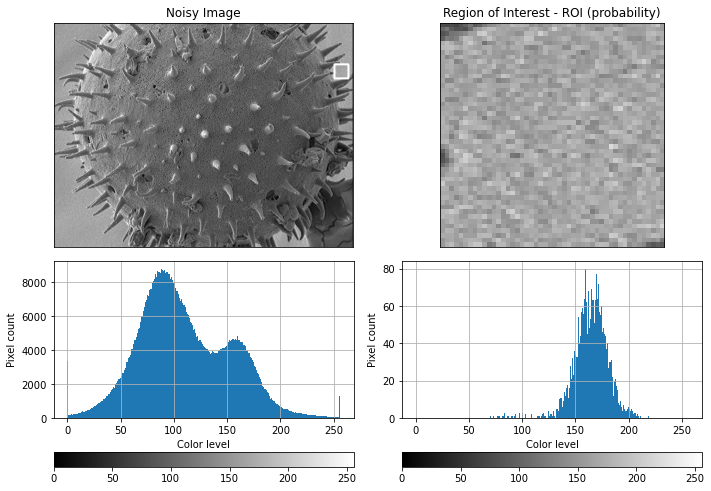

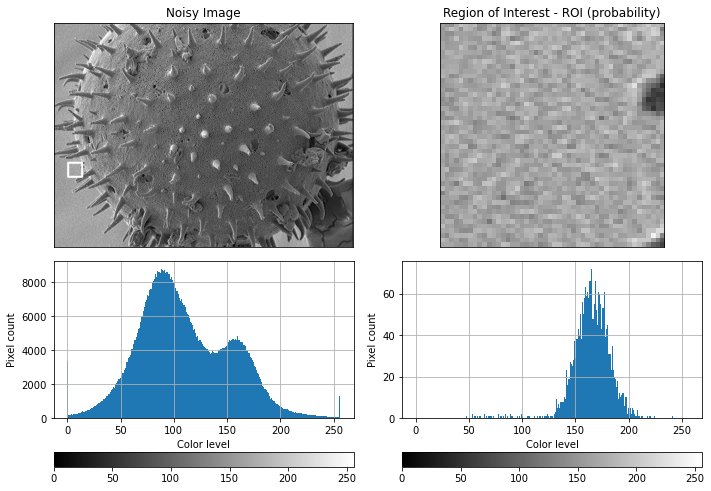

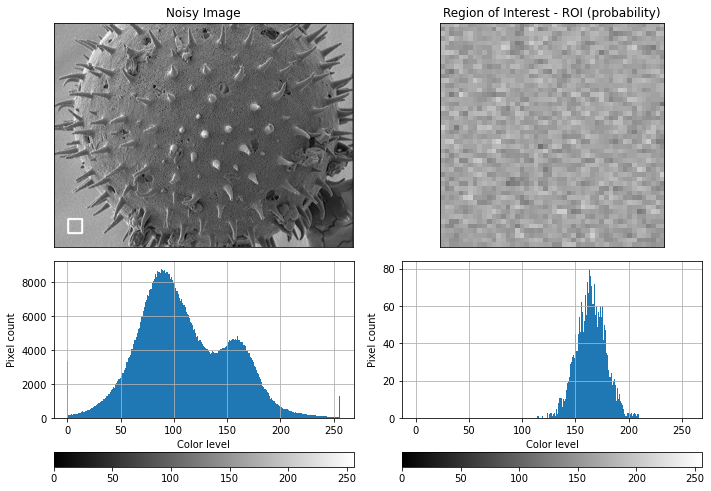

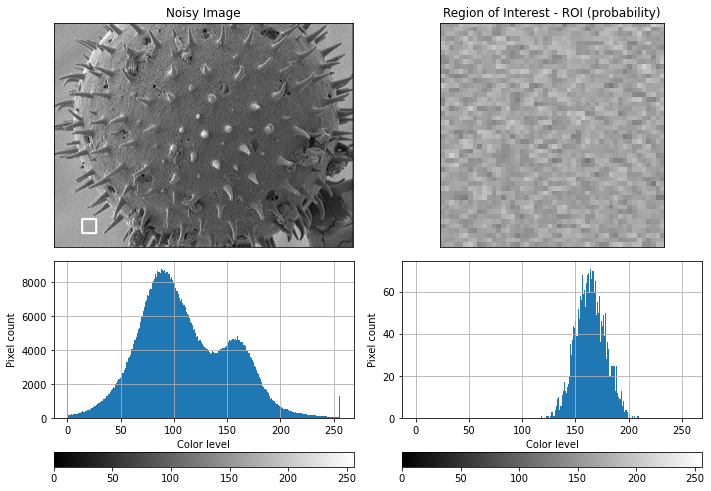

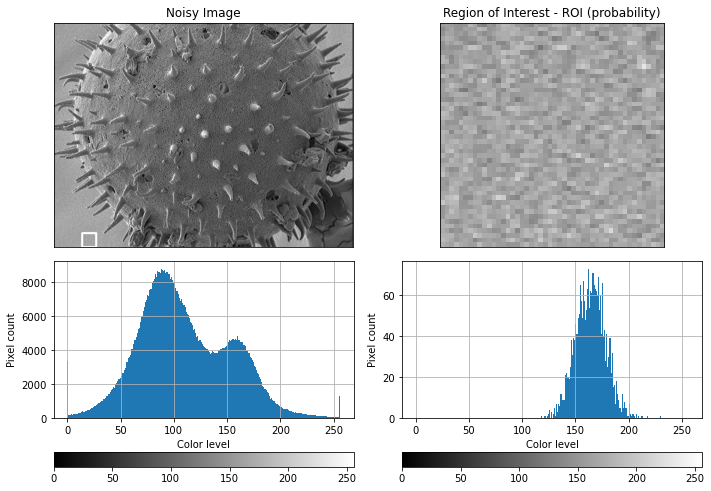

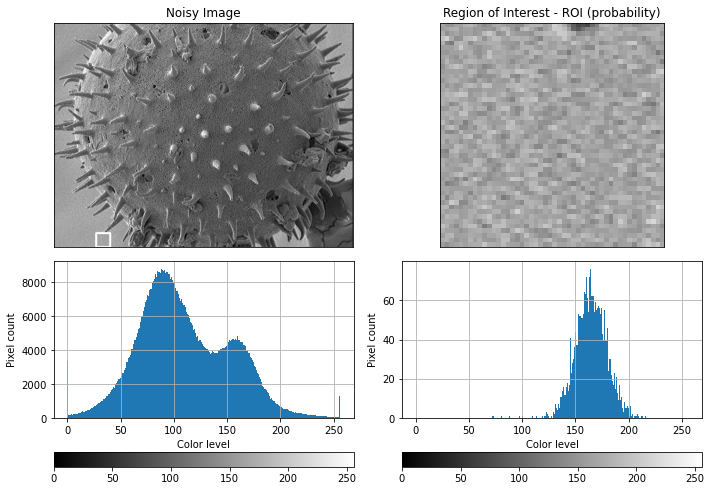

In [367]:
left,upper,right,lower, mean = tile('pollen.spd5.0098.png','SEM','out')
left_select,upper_select,right_select,lower_select = selectROI(left,upper,right,lower, mean)
smooth_parts = visualize_the_ROI('SEM/pollen.spd5.0098.png',left_select,upper_select,right_select,lower_select,'manual_noise/spd05.png')

In [368]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(smooth_parts[2].ravel())
print('Statistic: %.3f' % result.statistic)
p = 0
print(result.critical_values)
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 0.870
[0.575 0.655 0.786 0.916 1.09 ]
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.916, data looks normal (fail to reject H0)
1.000: 1.090, data looks normal (fail to reject H0)


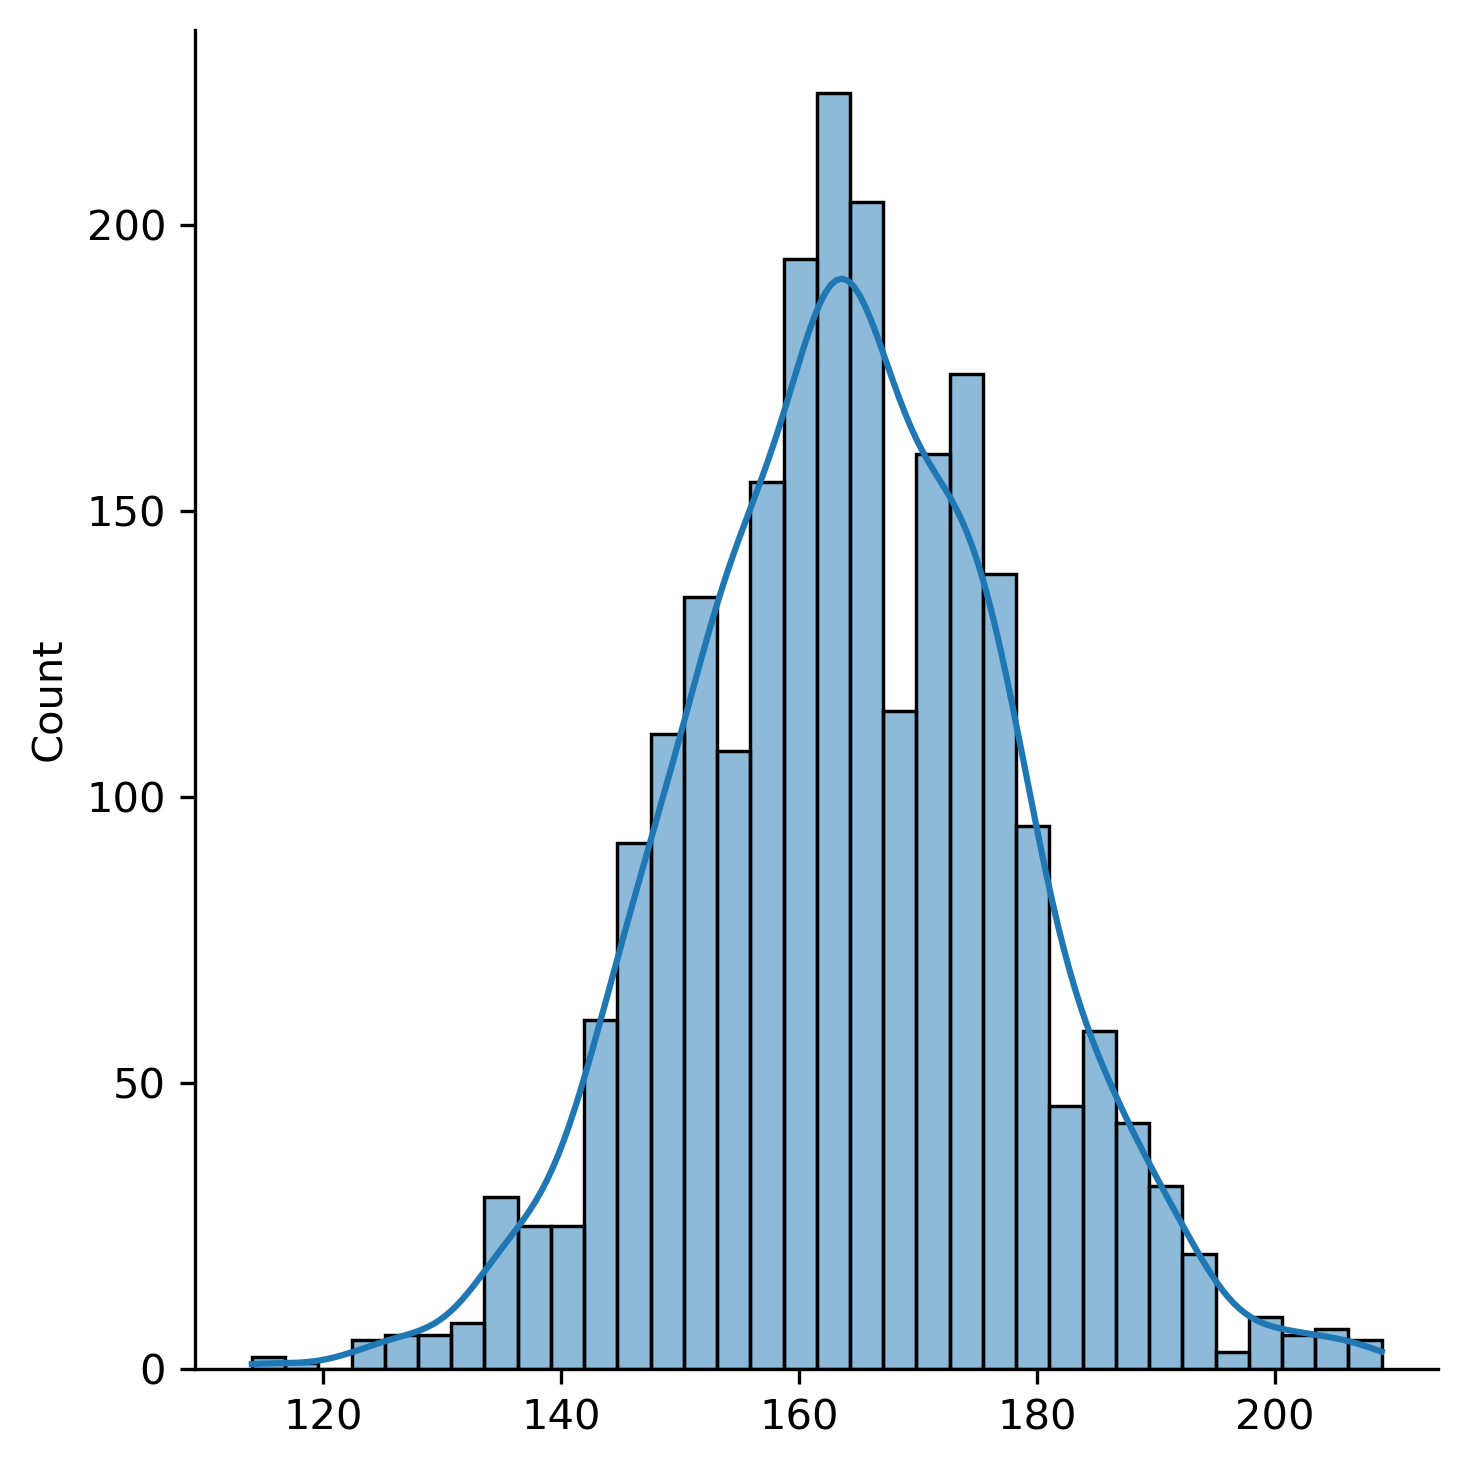

In [369]:
p = sns.displot(smooth_parts[2].ravel(), kde=True)
p.fig.set_dpi(300)
plt.savefig('manual_noise/validation/hist_scan_speed_05.png', dpi=300)


W      pval  normal
0  4.066831  0.130888    True

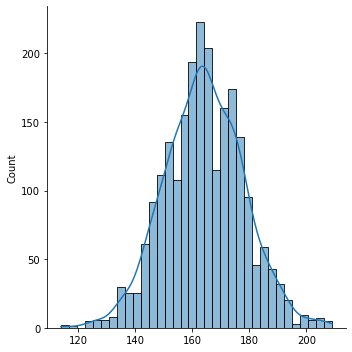

In [370]:
sns.displot(smooth_parts[2].ravel(), kde=True)
pg.normality(smooth_parts[2].ravel(),method="jarque_bera")

In [371]:
from scipy import stats
k2, p = stats.normaltest(smooth_parts[2].ravel())
#print(p)
alpha = 0.05
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.152965
The null hypothesis cannot be rejected


(array([  2.,   4.,   9.,  11.,  38.,  63., 134., 147., 264., 292., 355.,
        236., 285., 208., 110.,  64.,  47.,  14.,  11.,  10.]),
 array([114.  , 118.75, 123.5 , 128.25, 133.  , 137.75, 142.5 , 147.25,
        152.  , 156.75, 161.5 , 166.25, 171.  , 175.75, 180.5 , 185.25,
        190.  , 194.75, 199.5 , 204.25, 209.  ]),
 <BarContainer object of 20 artists>)

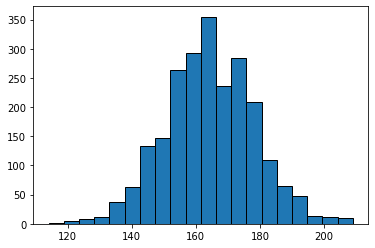

In [372]:
# Visual method
#make this example reproducible
np.random.seed(1)

#create histogram to visualize values in dataset
plt.hist(smooth_parts[2].ravel(), edgecolor='black', bins=20)

In [373]:
#Perform a Shapiro-Wilk Test

#make this example reproducible
np.random.seed(1)


#perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(smooth_parts[2].ravel())
alpha = 0.05
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.0361561
The null hypothesis can be rejected


# Residual Calculation Test

In [374]:
meangauss, sigmagauss, residialgauss = computeresidualgaussian(smooth_parts[2].ravel())
residialgauss

array([0.09898299, 0.09898299, 0.09898299, ..., 0.02092451, 0.02092451,
       0.02092451])

In [375]:
meanpois, sigmapois, residialpois = computeresidualpoisson(smooth_parts[2].ravel())
residialpois

array([0.09071649, 0.09071649, 0.09071649, ..., 0.04563138, 0.10048094,
       0.12845146])

In [376]:
type_noise = []
for i in range(0,len(residialgauss)):
    #for j in residialpois:
    if (residialgauss[i] - 0) > (residialpois[i]-0):
        type_noise.append('poison')
    else:
        type_noise.append('gaussian')
print('Poison pixels : ', str(type_noise.count('poison')))
print('Gaussian pixels : ', str(type_noise.count('gaussian')))

Poison pixels :  1057
Gaussian pixels :  1247


# Segmentation and Noise Estimation Scan speed 08

48


/tmp/ipykernel_2240/1017964780.py:48: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')
/tmp/ipykernel_2240/1017964780.py:57: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')


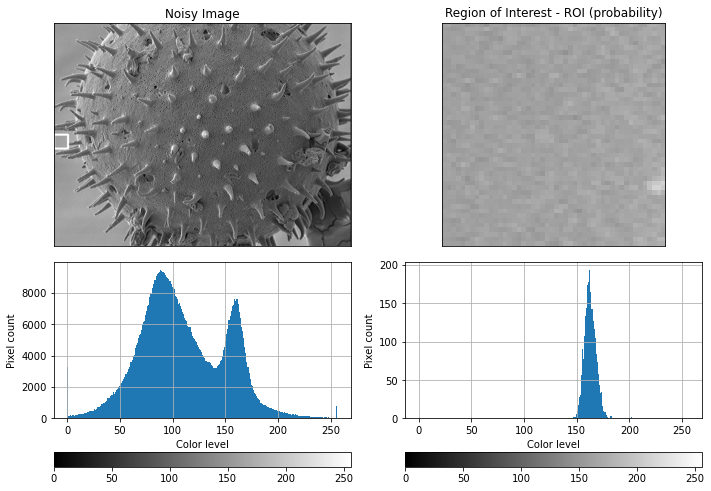

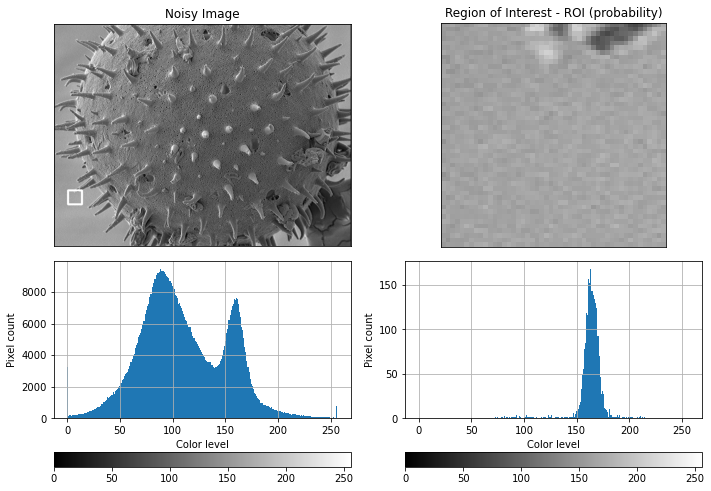

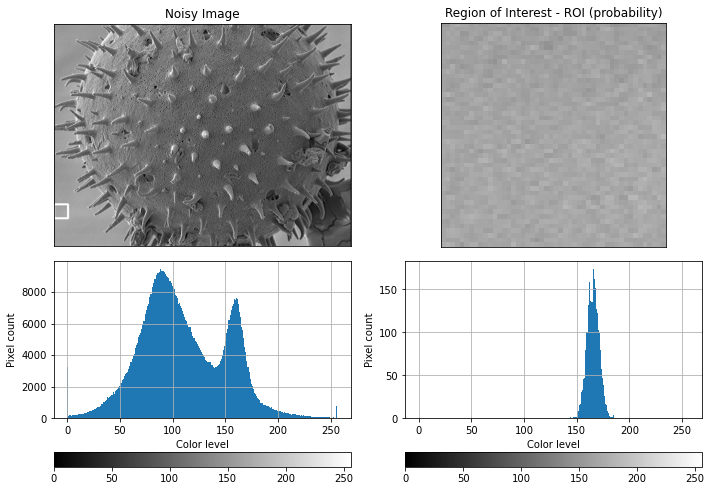

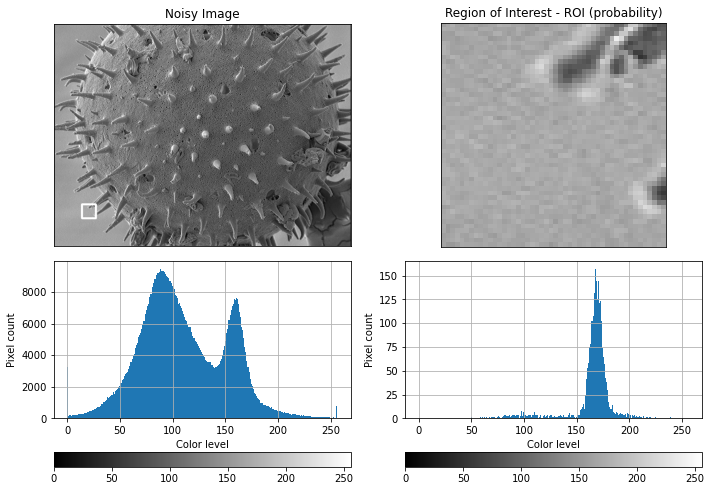

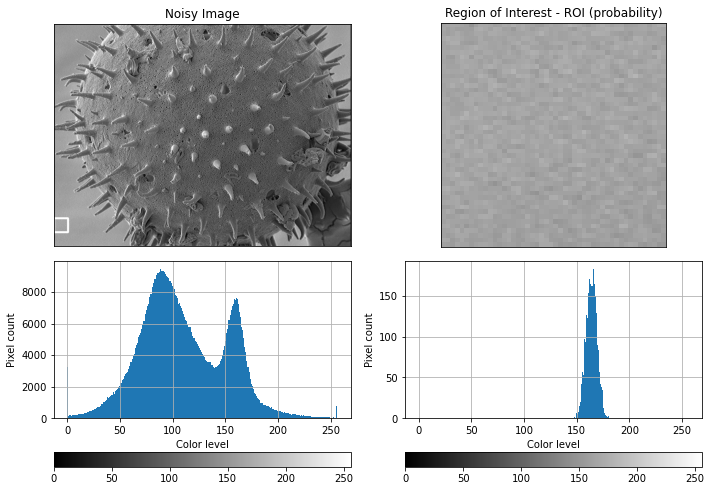

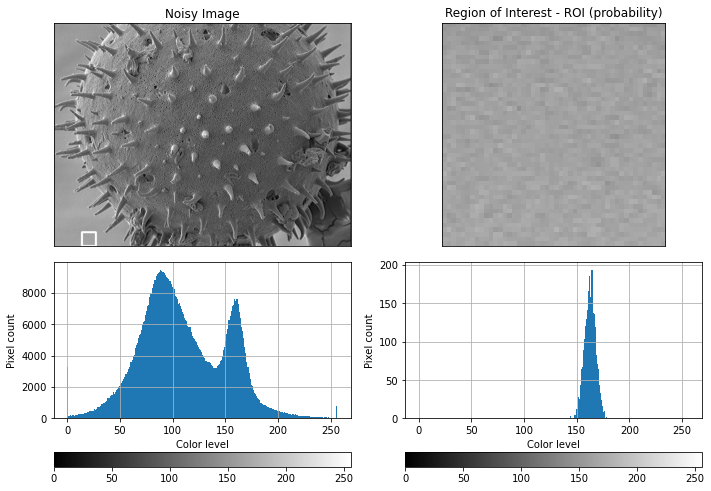

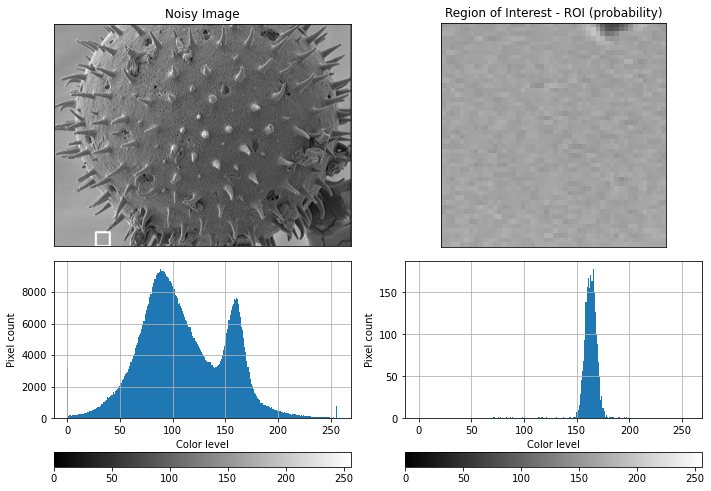

In [377]:
left,upper,right,lower, mean = tile('pollen.spd8.0098.png','SEM','out')
left_select,upper_select,right_select,lower_select = selectROI(left,upper,right,lower, mean)
smooth_parts = visualize_the_ROI('SEM/pollen.spd8.0098.png',left_select,upper_select,right_select,lower_select,'manual_noise/spd08.png')

In [378]:
from scipy import stats
k2, p = stats.normaltest(smooth_parts[4].ravel())
#print(p)
alpha = 1e-3
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.653993
The null hypothesis cannot be rejected


In [379]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(smooth_parts[4].ravel())
print('Statistic: %.3f' % result.statistic)
p = 0
print(result.critical_values)
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 3.688
[0.575 0.655 0.786 0.916 1.09 ]
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.916, data does not look normal (reject H0)
1.000: 1.090, data does not look normal (reject H0)


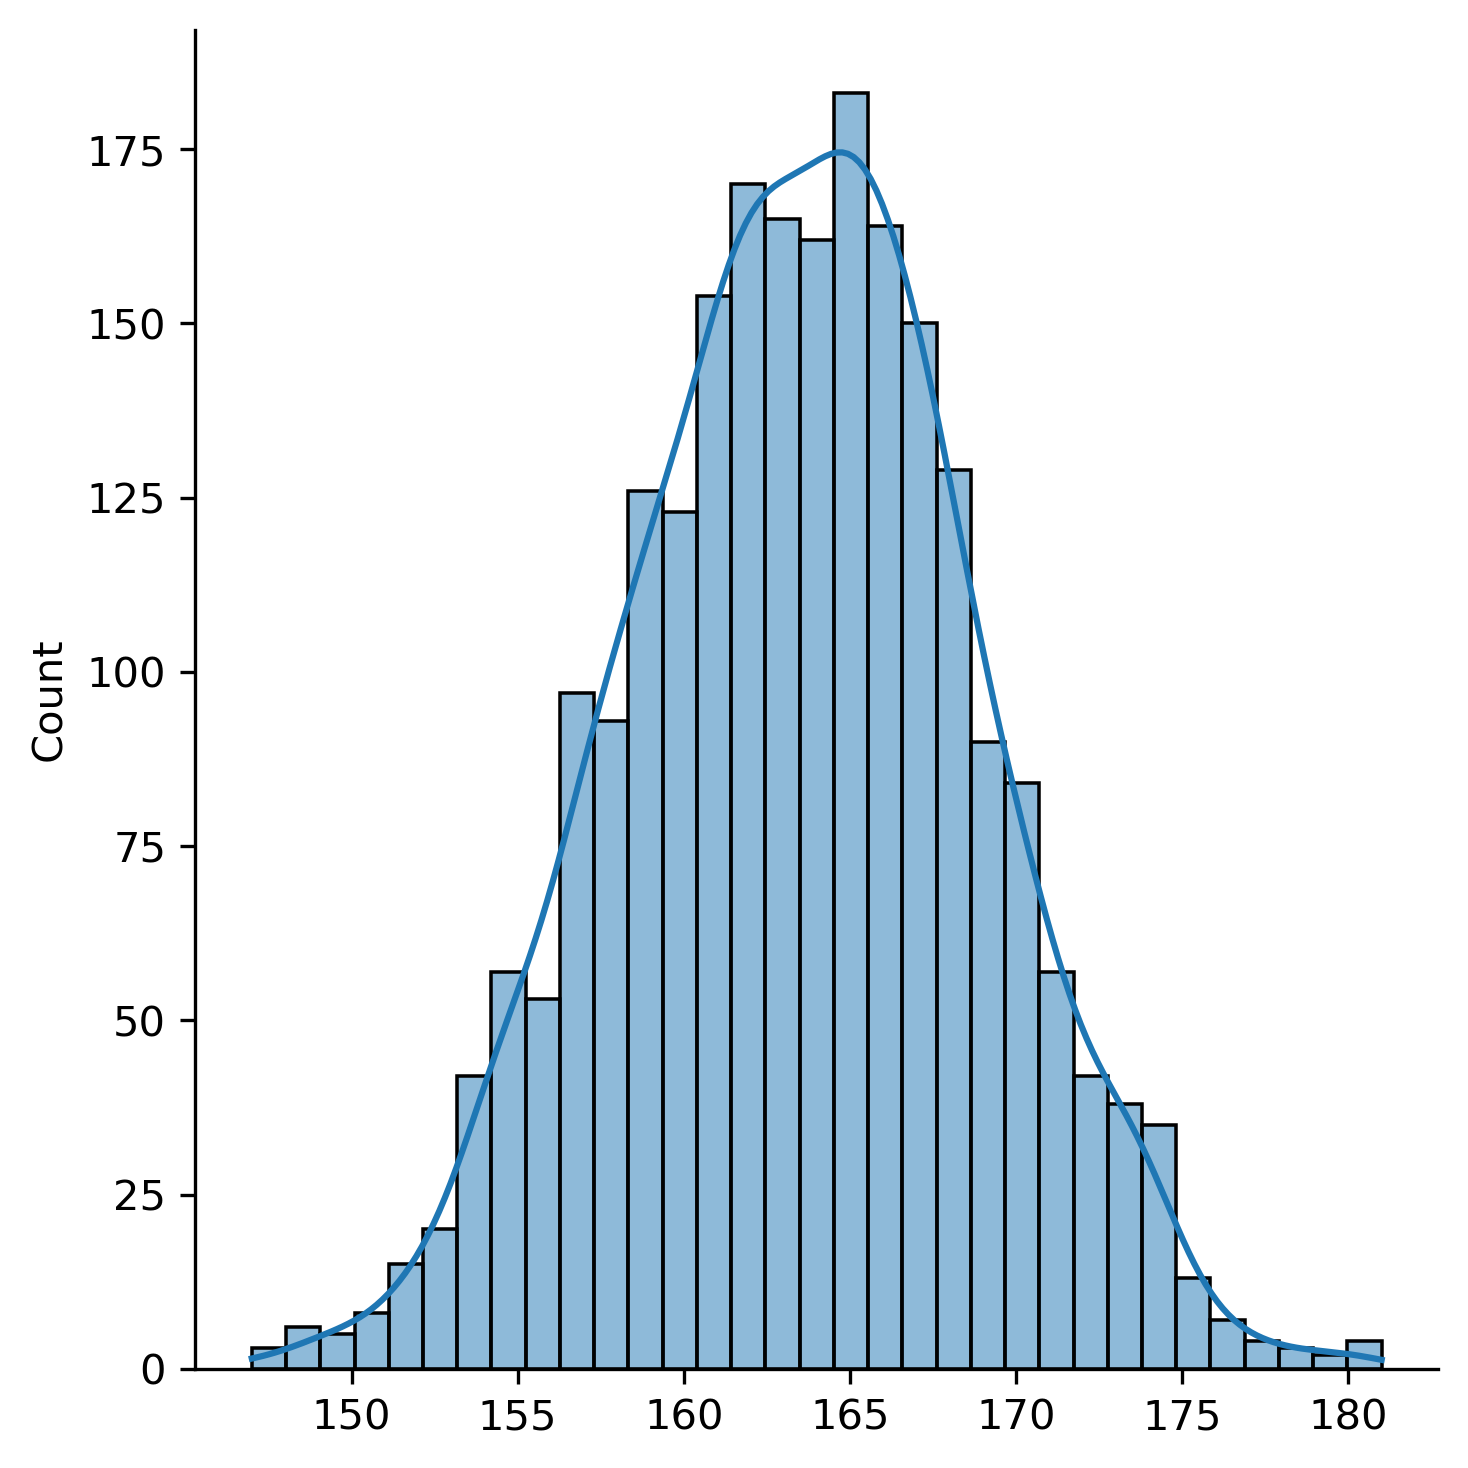

In [380]:
p = sns.displot(smooth_parts[4].ravel(), kde=True)
p.fig.set_dpi(300)
plt.savefig('manual_noise/validation/hist_scan_speed_08.png', dpi=300)


W      pval  normal
0  0.894047  0.639529    True

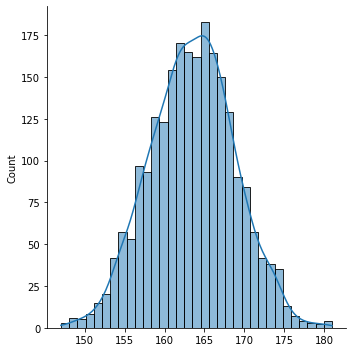

In [381]:
sns.displot(smooth_parts[4].ravel(), kde=True)
pg.normality(smooth_parts[4].ravel(),method="jarque_bera")

(array([  3.,  11.,  23.,  20.,  99., 150.,  93., 249., 324., 165., 345.,
        314., 219.,  84.,  99.,  73.,  13.,  11.,   5.,   4.]),
 array([147. , 148.7, 150.4, 152.1, 153.8, 155.5, 157.2, 158.9, 160.6,
        162.3, 164. , 165.7, 167.4, 169.1, 170.8, 172.5, 174.2, 175.9,
        177.6, 179.3, 181. ]),
 <BarContainer object of 20 artists>)

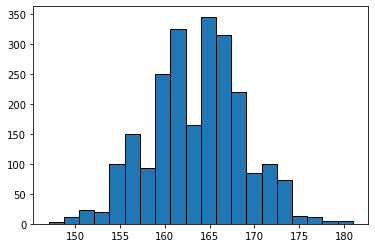

In [382]:
# Visual method
#make this example reproducible
np.random.seed(1)

#create histogram to visualize values in dataset
plt.hist(smooth_parts[4].ravel(), edgecolor='black', bins=20)

In [383]:
#Perform a Shapiro-Wilk Test

#make this example reproducible
np.random.seed(1)


#perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(smooth_parts[4].ravel())
alpha = 0.05
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 2.13204e-05
The null hypothesis can be rejected


# Residual Calculation Test

In [384]:
meangauss, sigmagauss, residialgauss = computeresidualgaussian(smooth_parts[4].ravel())
residialgauss

array([0.05394189, 1.4911792 , 1.26926255, ..., 0.05394189, 0.05394189,
       0.05394189])

In [385]:
meanpois, sigmapois, residialpois = computeresidualpoisson(smooth_parts[4].ravel())
residialpois

array([0.23307436, 0.23564469, 0.22809535, ..., 0.21125948, 0.0971365 ,
       0.12018256])

In [386]:
type_noise = []
for i in range(0,len(residialgauss)):
    #for j in residialpois:
    if (residialgauss[i] - 0) > (residialpois[i]-0):
        type_noise.append('poison')
    else:
        type_noise.append('gaussian')
print(type_noise.count('poison'))
print(type_noise.count('gaussian'))

899
1405


# Segmentation and Noise Estimation dwell time 25ns

48


/tmp/ipykernel_2240/1017964780.py:48: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')
/tmp/ipykernel_2240/1017964780.py:57: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')


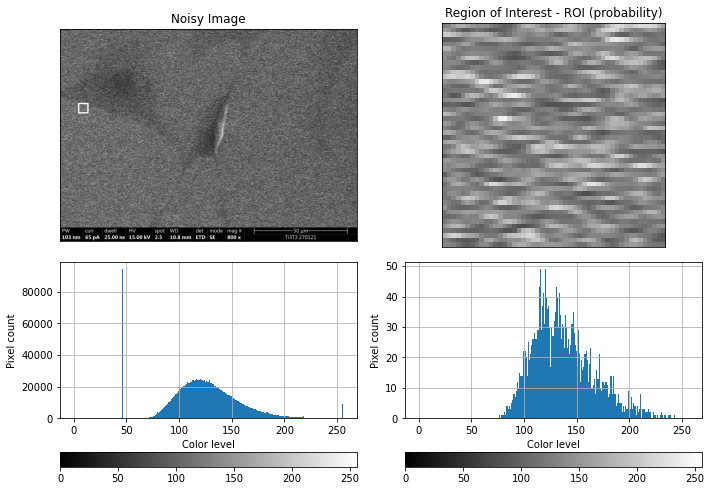

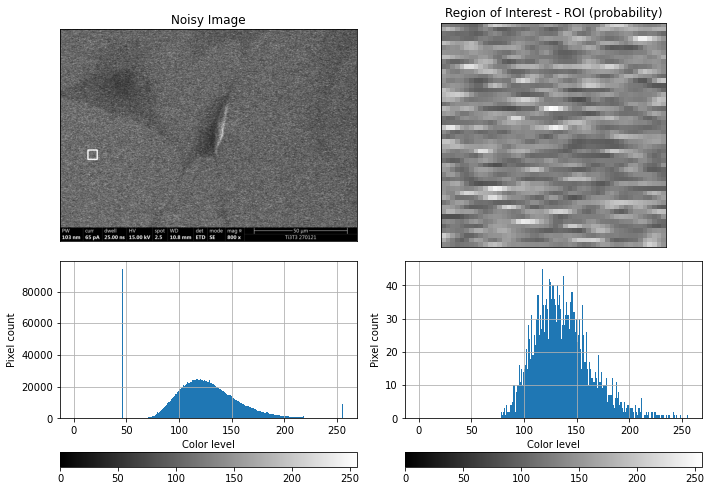

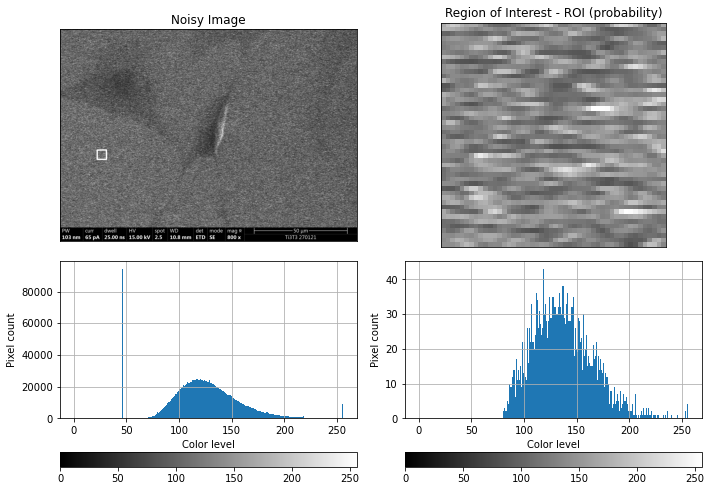

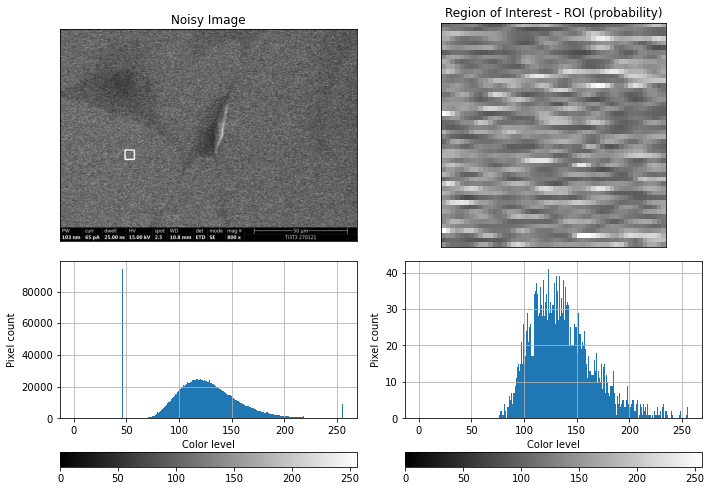

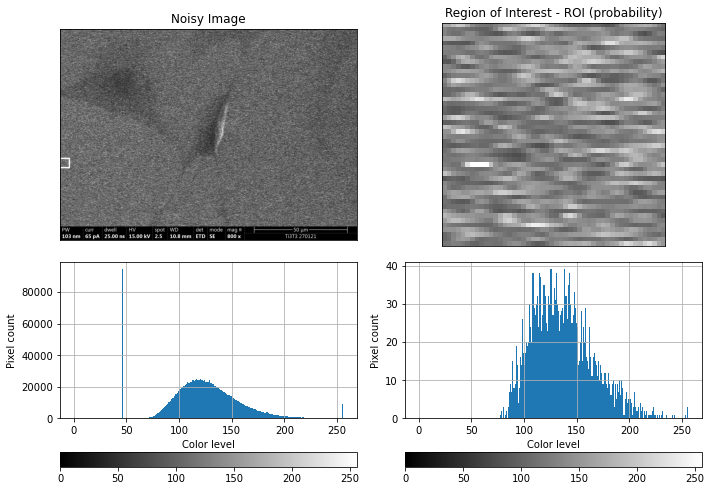

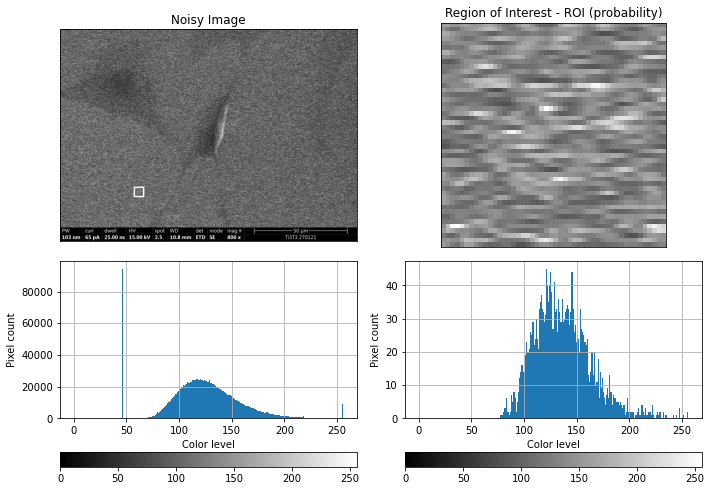

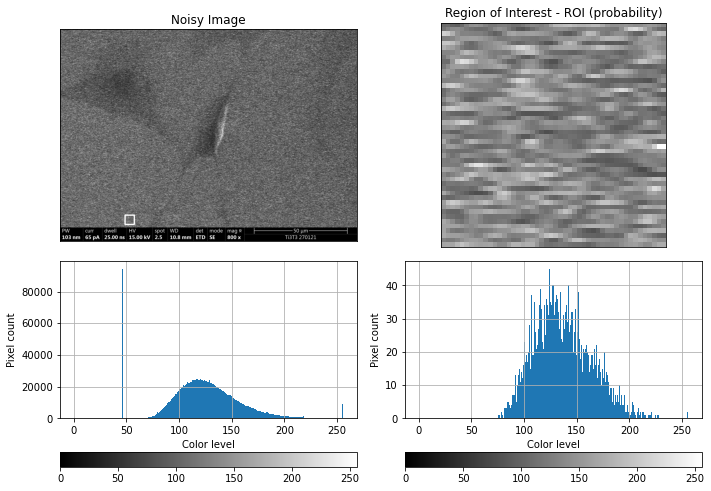

In [187]:
left,upper,right,lower, mean = tile('20210127-Ti3T3-25.00ns-2.5-008.tif','SEM','out')
left_select,upper_select,right_select,lower_select = selectROI(left,upper,right,lower, mean)
smooth_parts = visualize_the_ROI('SEM/20210127-Ti3T3-25.00ns-2.5-008.tif',left_select,upper_select,right_select,lower_select,'manual_noise/semdjon_25ns.png')

In [212]:
from scipy import stats
k2, p = stats.normaltest(smooth_parts[3].ravel())
#print(p)
alpha = 1e-3
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 3.13304e-54
The null hypothesis can be rejected


W  pval  normal
0  337.344156   0.0   False

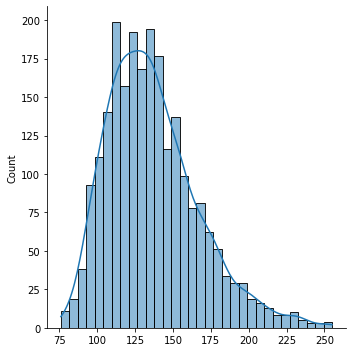

In [211]:
sns.displot(smooth_parts[3].ravel(), kde=True)
pg.normality(smooth_parts[3].ravel(),method="jarque_bera")

In [213]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(smooth_parts[3].ravel())
print('Statistic: %.3f' % result.statistic)
p = 0
print(result.critical_values)
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 21.664
[0.575 0.655 0.786 0.916 1.09 ]
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.916, data does not look normal (reject H0)
1.000: 1.090, data does not look normal (reject H0)


(array([ 16.,  66., 161., 241., 284., 286., 295., 241., 203., 136., 114.,
         89.,  49.,  41.,  28.,  20.,  10.,  14.,   3.,   7.]),
 array([ 76.  ,  84.95,  93.9 , 102.85, 111.8 , 120.75, 129.7 , 138.65,
        147.6 , 156.55, 165.5 , 174.45, 183.4 , 192.35, 201.3 , 210.25,
        219.2 , 228.15, 237.1 , 246.05, 255.  ]),
 <BarContainer object of 20 artists>)

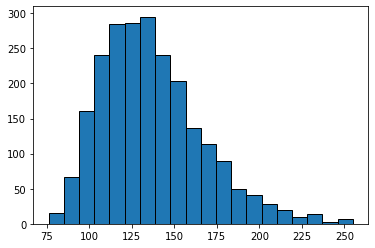

In [214]:
# Visual method
#make this example reproducible
np.random.seed(1)

#create histogram to visualize values in dataset
plt.hist(smooth_parts[3].ravel(), edgecolor='black', bins=20)

In [215]:
#Perform a Shapiro-Wilk Test

#make this example reproducible
np.random.seed(1)


#perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(smooth_parts[3].ravel())
alpha = 0.001
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 3.07834e-25
The null hypothesis can be rejected


# Residual Calculation Test

In [216]:
meangauss, sigmagauss, residialgauss = computeresidualgaussian(smooth_parts[3].ravel())
residialgauss

array([0.01050031, 0.01050031, 0.01050031, ..., 0.00772817, 0.00935506,
       0.03551075])

In [217]:
meanpois, sigmapois, residialpois = computeresidualpoisson(smooth_parts[3].ravel())
residialpois

array([0.06118148, 0.07718925, 0.20229982, ..., 0.0104858 , 0.00863394,
       0.04212081])

In [218]:
type_noise = []
for i in range(0,len(residialgauss)):
    #for j in residialpois:
    if (residialgauss[i] - 0) > (residialpois[i]-0):
        type_noise.append('poison')
    else:
        type_noise.append('gaussian')
print('Poison pixels : ', str(type_noise.count('poison')))
print('Gaussian pixels : ', str(type_noise.count('gaussian')))

Poison pixels :  683
Gaussian pixels :  1621
